In [1]:
!pip install apafib --upgrade --quiet

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

In [3]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

from sklearn.model_selection import GridSearchCV

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [4]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

# **Problema grupal: Desbalance**

En los dominios médicos, suele haber un desequilibrio entre las clases a predecir dado que muchas veces hay más datos para la condición normal que para las otras condiciones. Esto dificulta la obtención de un modelo con buena calidad que realmente discrimine las clases que nos interesan. El conjunto de datos MIT-BIH Arrhythmia Database3 es un conjunto de datos que recopila ECGs de pacientes y tiene anotaciones médicas indicando latidos que corresponden a diferentes problemas de corazón, pero especialmente arritmias. Vamos a trabajar con un conjunto de datos reducido generado a partir del original. En el conjunto de datos que trataréis hay cuatro arritmias diferentes, más latidos normales. El objetivo es obtener un clasificador que sea capaz de distinguir entre las diferentes clases.

### Lectura de los datos

Antes de manipular los datos debemos leerlos:

In [5]:
from apafib import load_MITBIH
MITBIH_data = load_MITBIH()

# Reordenamos las columnas de manera que la variable respuesta sea la primera
cols = list(MITBIH_data.columns)
cols.remove('target')
cols.insert(0, 'target')
MITBIH_data = MITBIH_data.reindex(columns=cols)

MITBIH_data.head()

target      0      1      2      3      4      5      6      7      8  ...  \
0  Normal  0.989  0.226  0.005  0.068  0.045  0.053  0.078  0.078  0.107  ...   
1    ArrS  0.988  0.256  0.015  0.136  0.150  0.145  0.261  0.331  0.324  ...   
2    ArrS  0.976  0.541  0.056  0.001  0.047  0.024  0.048  0.034  0.043  ...   
3  Normal  0.989  0.641  0.211  0.154  0.144  0.114  0.137  0.111  0.124  ...   
4  Normal  0.719  0.414  0.123  0.059  0.055  0.043  0.061  0.057  0.080  ...   

          84         85         86         87         88         89  \
0  4.552e-06 -2.683e-05  3.679e-05 -3.470e-05  2.393e-05 -9.375e-06   
1 -1.027e-04 -6.225e-05  1.719e-04 -2.104e-04  1.843e-04 -1.155e-04   
2  1.018e-03 -4.076e-04 -6.715e-05  4.167e-04 -6.117e-04  6.276e-04   
3  1.283e-05 -1.145e-05  7.374e-06 -2.317e-06 -2.159e-06  5.005e-06   
4  1.593e-05  3.020e-06 -1.671e-05  2.277e-05 -2.138e-05  1.466e-05   

          90         91         92         93  
0 -4.229e-06  1.348e-05 -1.691e-05  1.493e-05  
1  3.224e-05  3.992e-05 -8.427e-05  9.528e-05  
2 -4.793e-04  2.328e-04  2.478e-05 -2.191e-04  
3 -5.845e-06  4.919e-06 -2.885e-06  5.438e-07  
4 -5.624e-06 -2.775e-06  8.442e-06 -1.048e-05  

[5 rows x 95 columns]

### Análisis exploratorio de los datos

Siempre es una buena idea hacer una pequeña exploración de los datos. Los datos reales necesitan procesamiento previo y es importante comprender su conjunto de datos para poder tomar buenas decisiones de diseño.

Vamos a hacer una visualización rápida de los datos. En esta visualización usamos histogramas para mostrar la distribución de las variables numéricas y diagramas de barras para las categóricas.

Con este tipo de visualizaciones fáciles, podemos ver mucha información relevante sobre nuestros datos, como si tenemos nuestros valores o si alguna variable se ha codificado incorrectamente, o si "parece" lo suficientemente gaussiana.

In [6]:
print(f"En nuestros datos tenemos {MITBIH_data.shape[1]} columnas (1 es la variable objetivo)\n")
MITBIH_data.describe(include='all').T
MITBIH_data.info()

En nuestros datos tenemos 95 columnas (1 es la variable objetivo)



count unique     top  freq   mean    std    min    25%    50%    75%  \
target    8755      5  Normal  7263    NaN    NaN    NaN    NaN    NaN    NaN   
0       8755.0    NaN     NaN   NaN  0.876  0.245 -0.003  0.909   0.98  0.989   
1       8755.0    NaN     NaN   NaN  0.441  0.192 -0.007  0.297  0.435  0.568   
2       8755.0    NaN     NaN   NaN  0.175  0.183 -0.052   0.05  0.112  0.234   
3       8755.0    NaN     NaN   NaN  0.203  0.177 -0.028  0.073  0.141  0.302   
...        ...    ...     ...   ...    ...    ...    ...    ...    ...    ...   
89      8755.0    NaN     NaN   NaN  0.005  0.043 -0.087   -0.0    0.0    0.0   
90      8755.0    NaN     NaN   NaN  0.004  0.041 -0.036   -0.0    0.0    0.0   
91      8755.0    NaN     NaN   NaN  0.004  0.041 -0.073   -0.0    0.0    0.0   
92      8755.0    NaN     NaN   NaN  0.004  0.037 -0.033   -0.0    0.0    0.0   
93      8755.0    NaN     NaN   NaN  0.003  0.034 -0.017   -0.0    0.0    0.0   

          max  
target    NaN  
0       0.991  
1       1.008  
2       1.008  
3       0.988  
...       ...  
89      0.821  
90      0.825  
91      0.963  
92      0.854  
93      0.849  

[95 rows x 11 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8755 entries, 0 to 8754
Data columns (total 95 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  8755 non-null   object 
 1   0       8755 non-null   float64
 2   1       8755 non-null   float64
 3   2       8755 non-null   float64
 4   3       8755 non-null   float64
 5   4       8755 non-null   float64
 6   5       8755 non-null   float64
 7   6       8755 non-null   float64
 8   7       8755 non-null   float64
 9   8       8755 non-null   float64
 10  9       8755 non-null   float64
 11  10      8755 non-null   float64
 12  11      8755 non-null   float64
 13  12      8755 non-null   float64
 14  13      8755 non-null   float64
 15  14      8755 non-null   float64
 16  15      8755 non-null   float64
 17  16      8755 non-null   float64
 18  17      8755 non-null   float64
 19  18      8755 non-null   float64
 20  19      8755 non-null   float64
 21  20      8755 non-null   float64
 22  

En este dataset vemos que no hay variables categóricas así que nos ahorramos la realizacion de un one-hot encoding

Vemos que no tenemos valores faltantes

<Axes: >

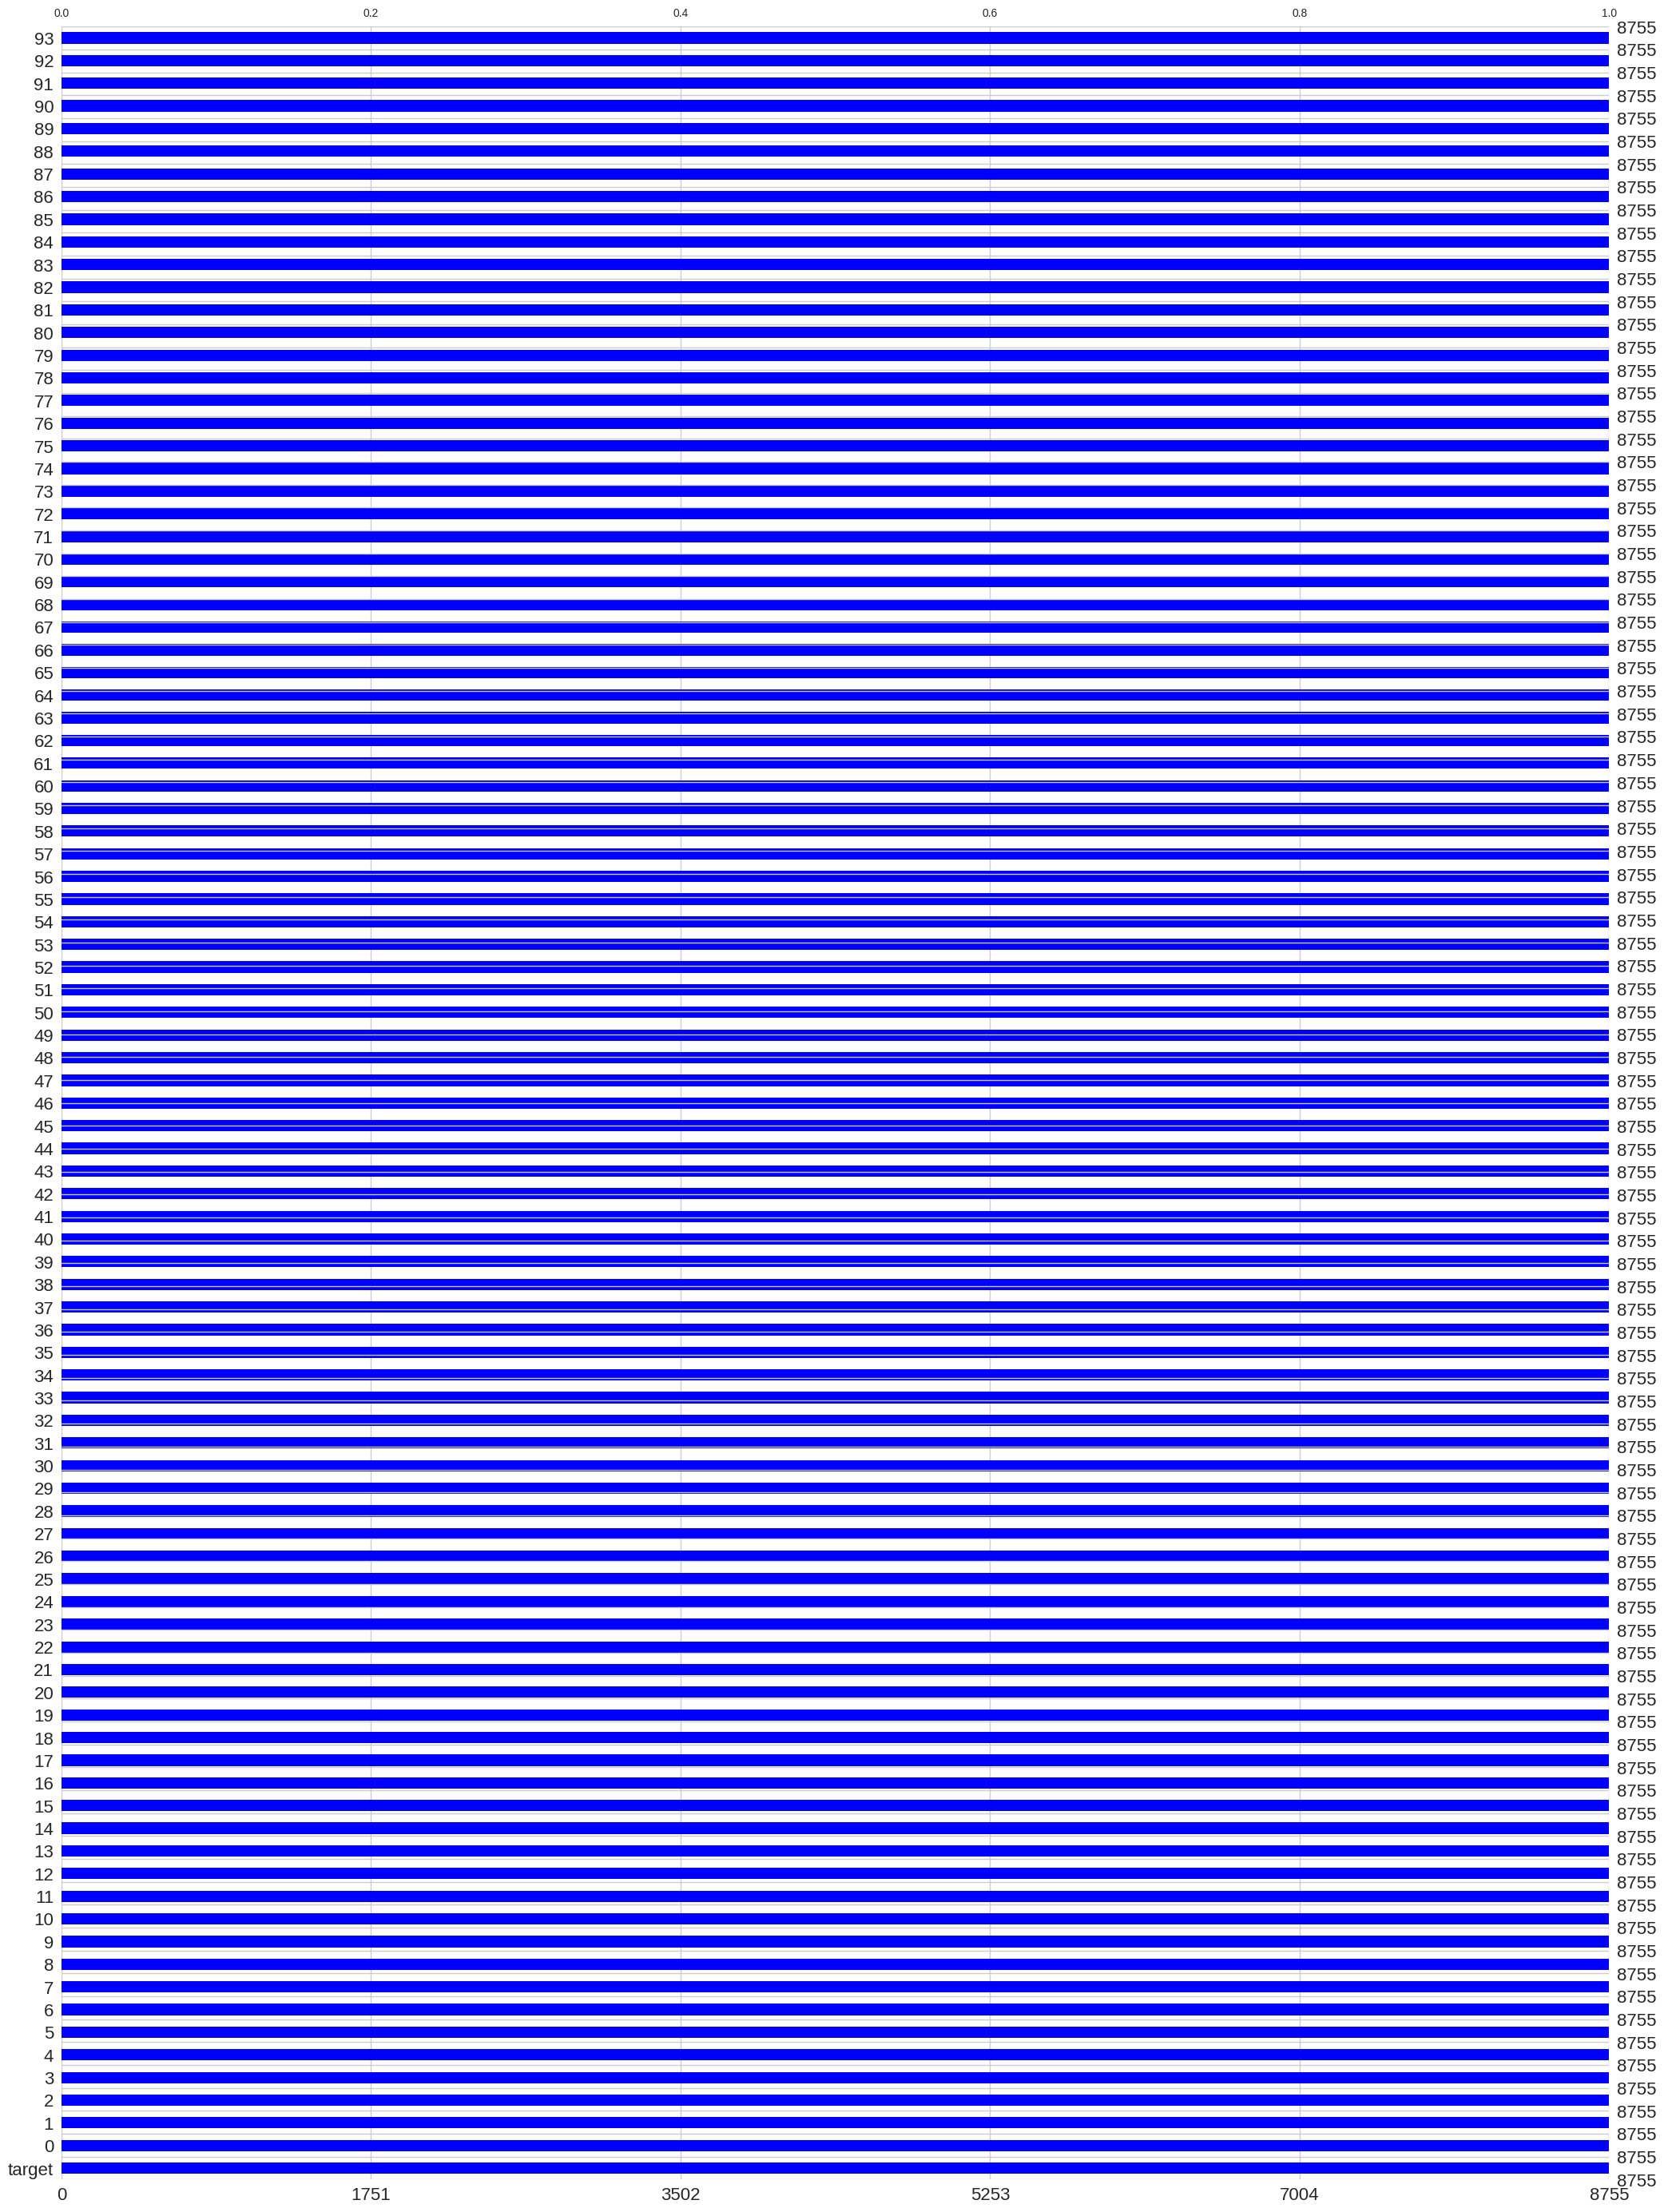

In [7]:
import missingno as msno
msno.bar(MITBIH_data, color="blue")

### Balanceo de los datos
Dado que nuestro conjunto de datos pretende clasificar una serie de clases, procedemos a mostrar cuantas instancias de cada clase tenemos

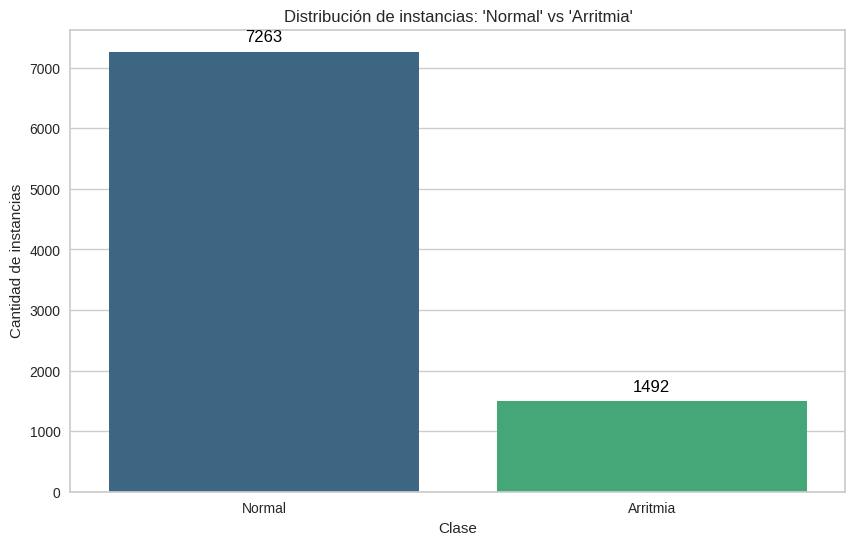

In [8]:
normal_count = MITBIH_data['target'].value_counts().get('Normal', 0)  # Cantidad de 'Normal'
non_normal_count = MITBIH_data['target'][MITBIH_data['target'] != 'Normal'].value_counts().sum()  # Cantidad de 'No Normal'

data_to_plot = pd.DataFrame({
    'Clase': ['Normal'] + ['Arritmia'],
    'Cantidad': [normal_count] + [non_normal_count]
})


plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Clase', y='Cantidad', data=data_to_plot, palette="viridis")

for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=12, color='black',
                      xytext=(0, 5),
                      textcoords='offset points')

plt.xlabel("Clase")
plt.ylabel("Cantidad de instancias")
plt.title("Distribución de instancias: 'Normal' vs 'Arritmia'")
plt.show();

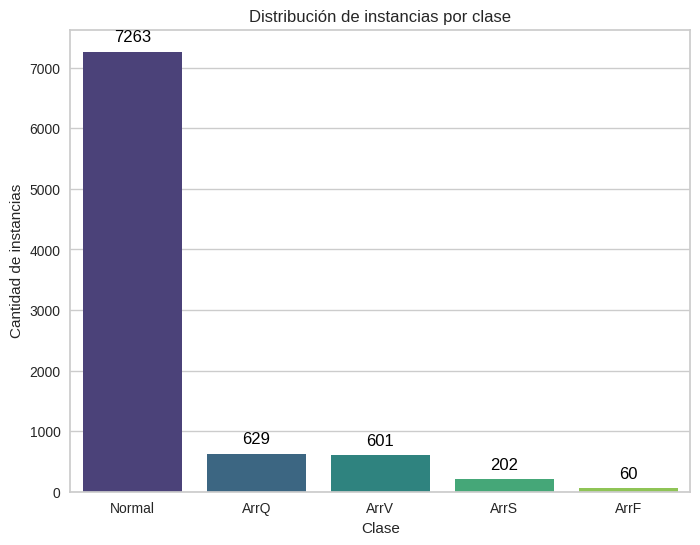

In [9]:
class_counts = MITBIH_data['target'].value_counts()

plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=12, color='black',
                      xytext=(0, 5),
                      textcoords='offset points')

plt.xlabel("Clase")
plt.ylabel("Cantidad de instancias")
plt.title("Distribución de instancias por clase")
plt.show();

Observamos que hay un desbalanceo muy pronunciado en los datos. Vemos que la cantidad de ejemplos de no arritmias es de 7263 y las de arritmia forman solo 1492 instancias.

Por otra parte si indagamos en las clases de Arritmias aun nos encontramos un desbalanceo mas exagerado, vemos como hay una clase ArrF que contiene solo un 4% de todsas las Arritmias.

Debido al gran desbalanceo es muy probable que no obtengamos predicciones muy acertadas en las clases con menos instancias y debamos aplicar un OverSampling con algun método avanzado como SMOTE, ADASYN o un Random Oversampling.

### Visualización
Realizamos ahora una visualizacion de las distribuciones de las variables

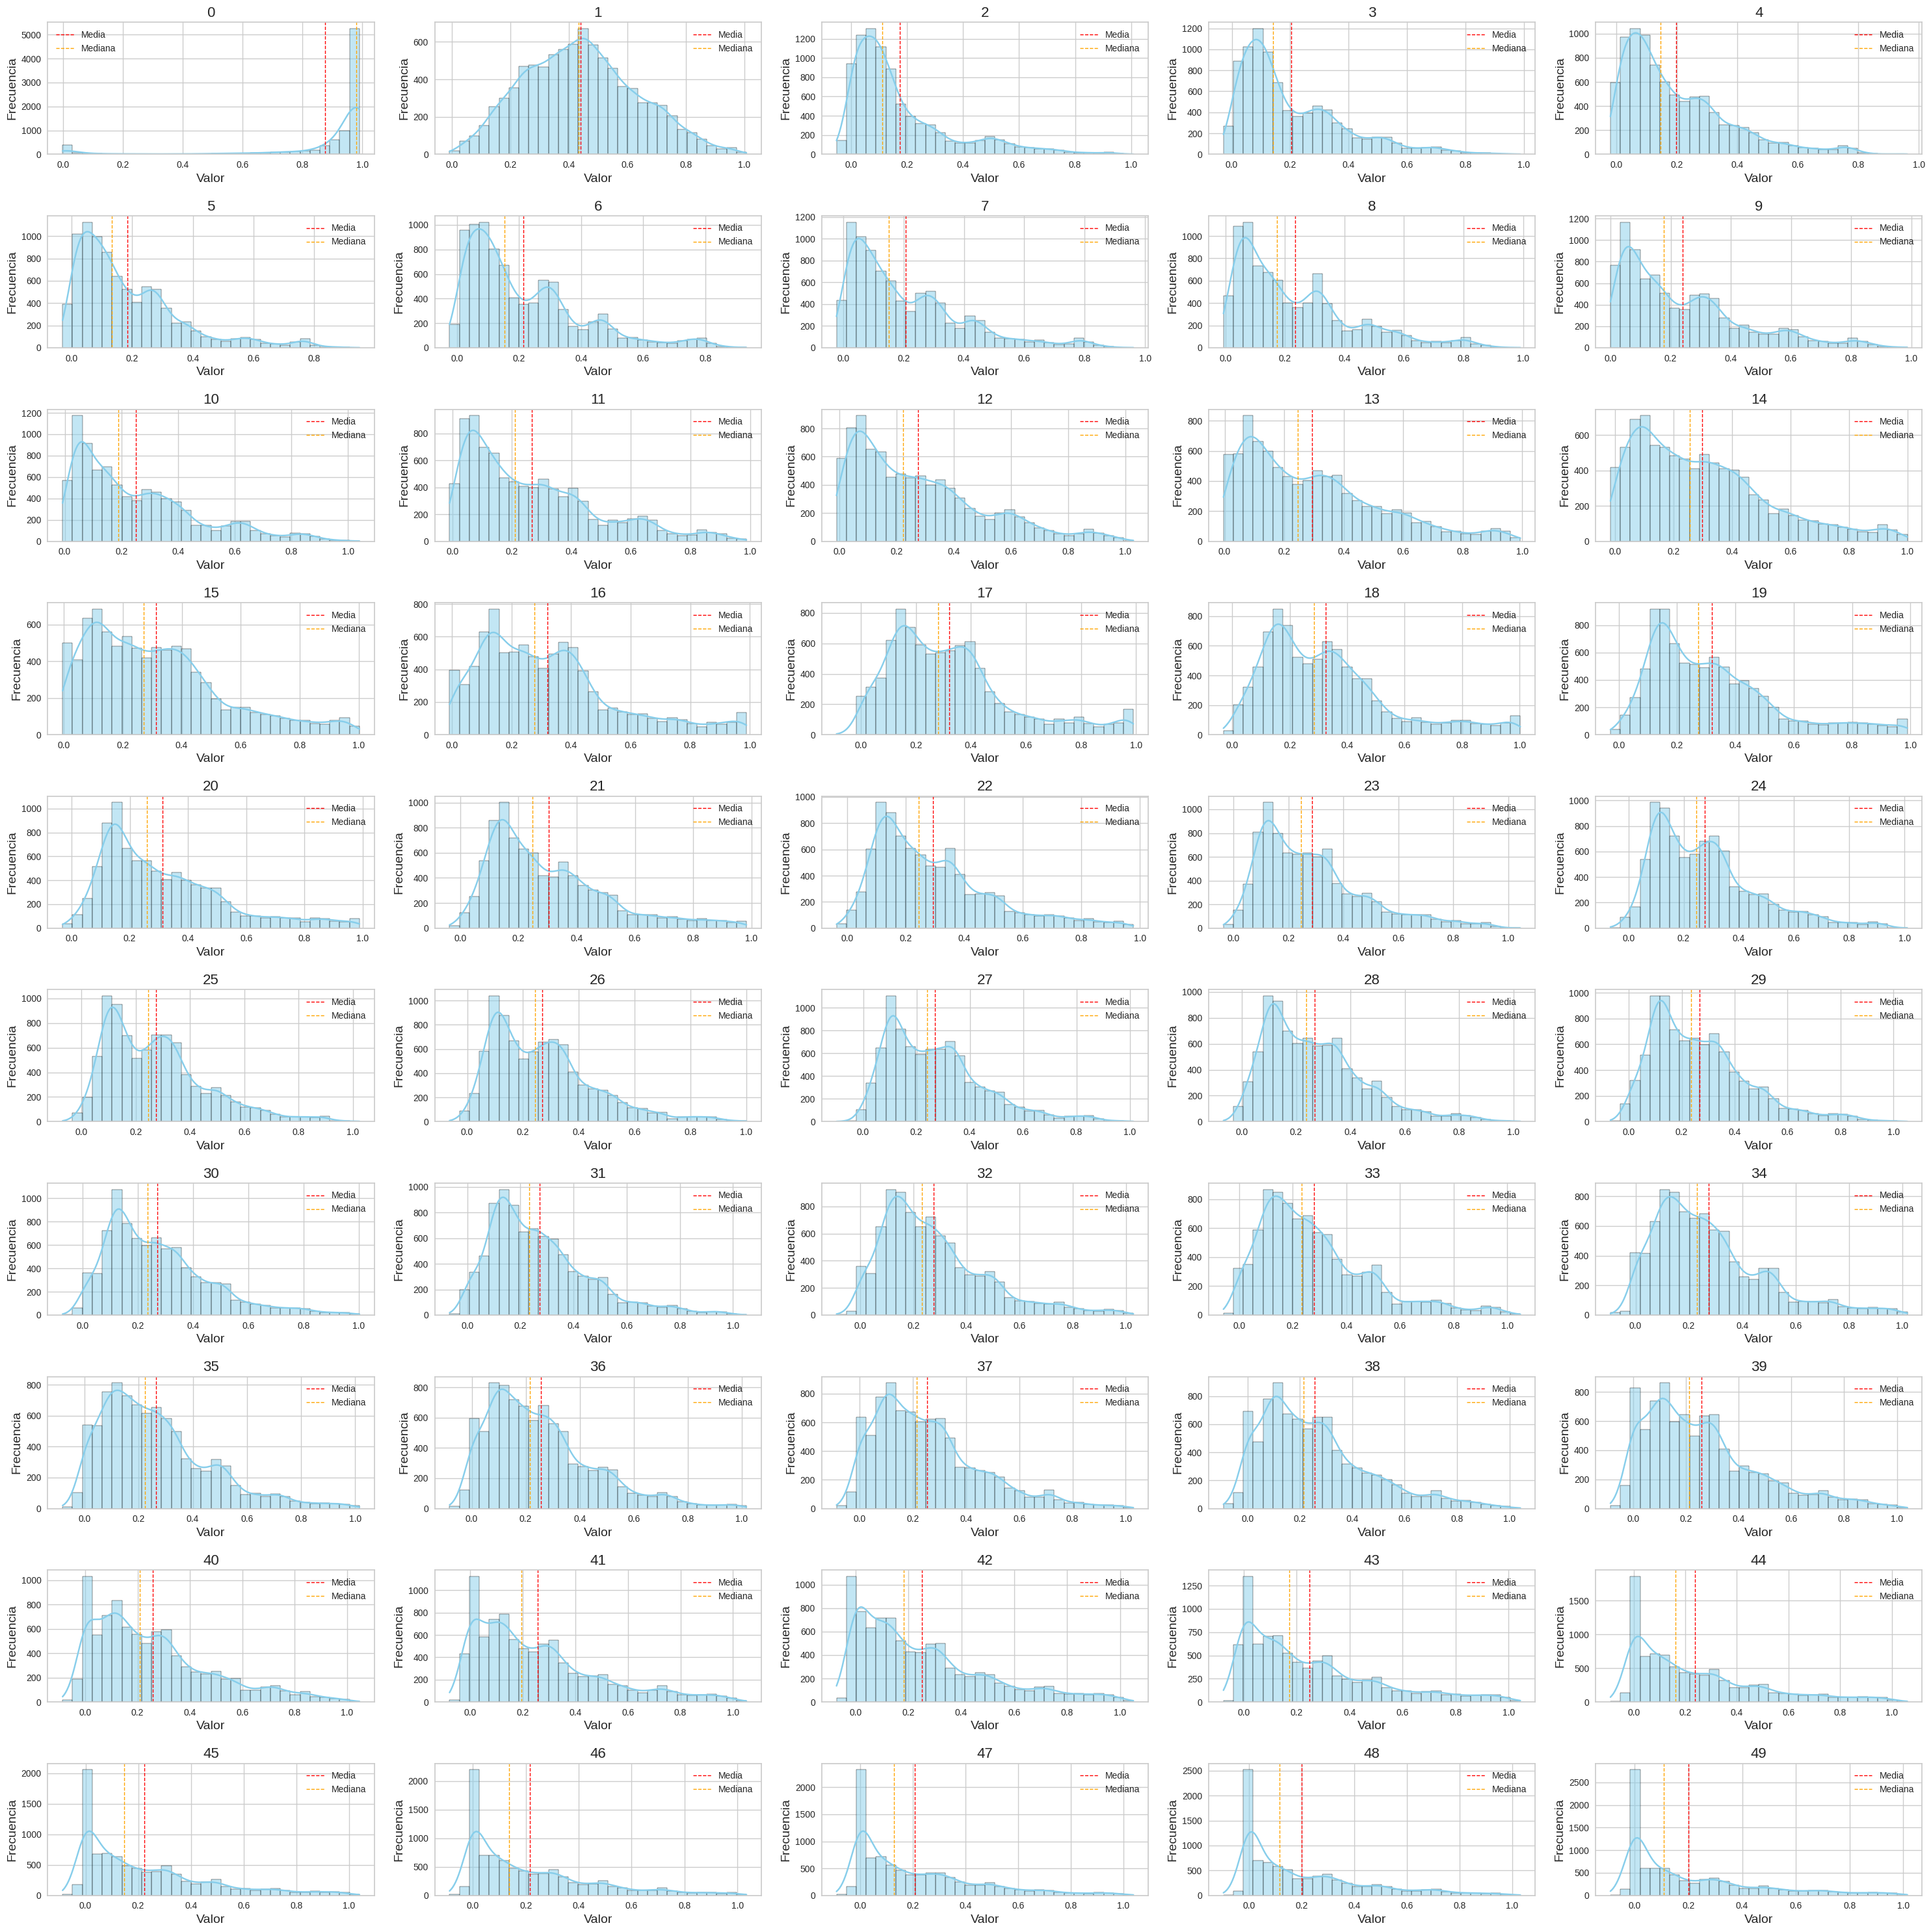

In [10]:
fig, axes = plt.subplots(10, 5, figsize=(30, 30))

MITBIH_data_no_target = MITBIH_data.drop(columns=['target'])
MITBIH_data_first_50_cols = MITBIH_data_no_target.iloc[:, :50]

for i, c in enumerate(MITBIH_data_first_50_cols.columns):
    ax = axes.flatten()[i]
    sns.histplot(data=MITBIH_data_first_50_cols, x=c, ax=ax, bins=30, kde=True, color='skyblue')
    ax.set_title(c, fontsize=16)
    ax.set_xlabel('Valor', fontsize=14)
    ax.set_ylabel('Frecuencia', fontsize=14)

    mean = MITBIH_data_first_50_cols[c].mean()
    median = MITBIH_data_first_50_cols[c].median()
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Media')
    ax.axvline(median, color='orange', linestyle='dashed', linewidth=1, label='Mediana')
    ax.legend()

plt.tight_layout();
plt.show();

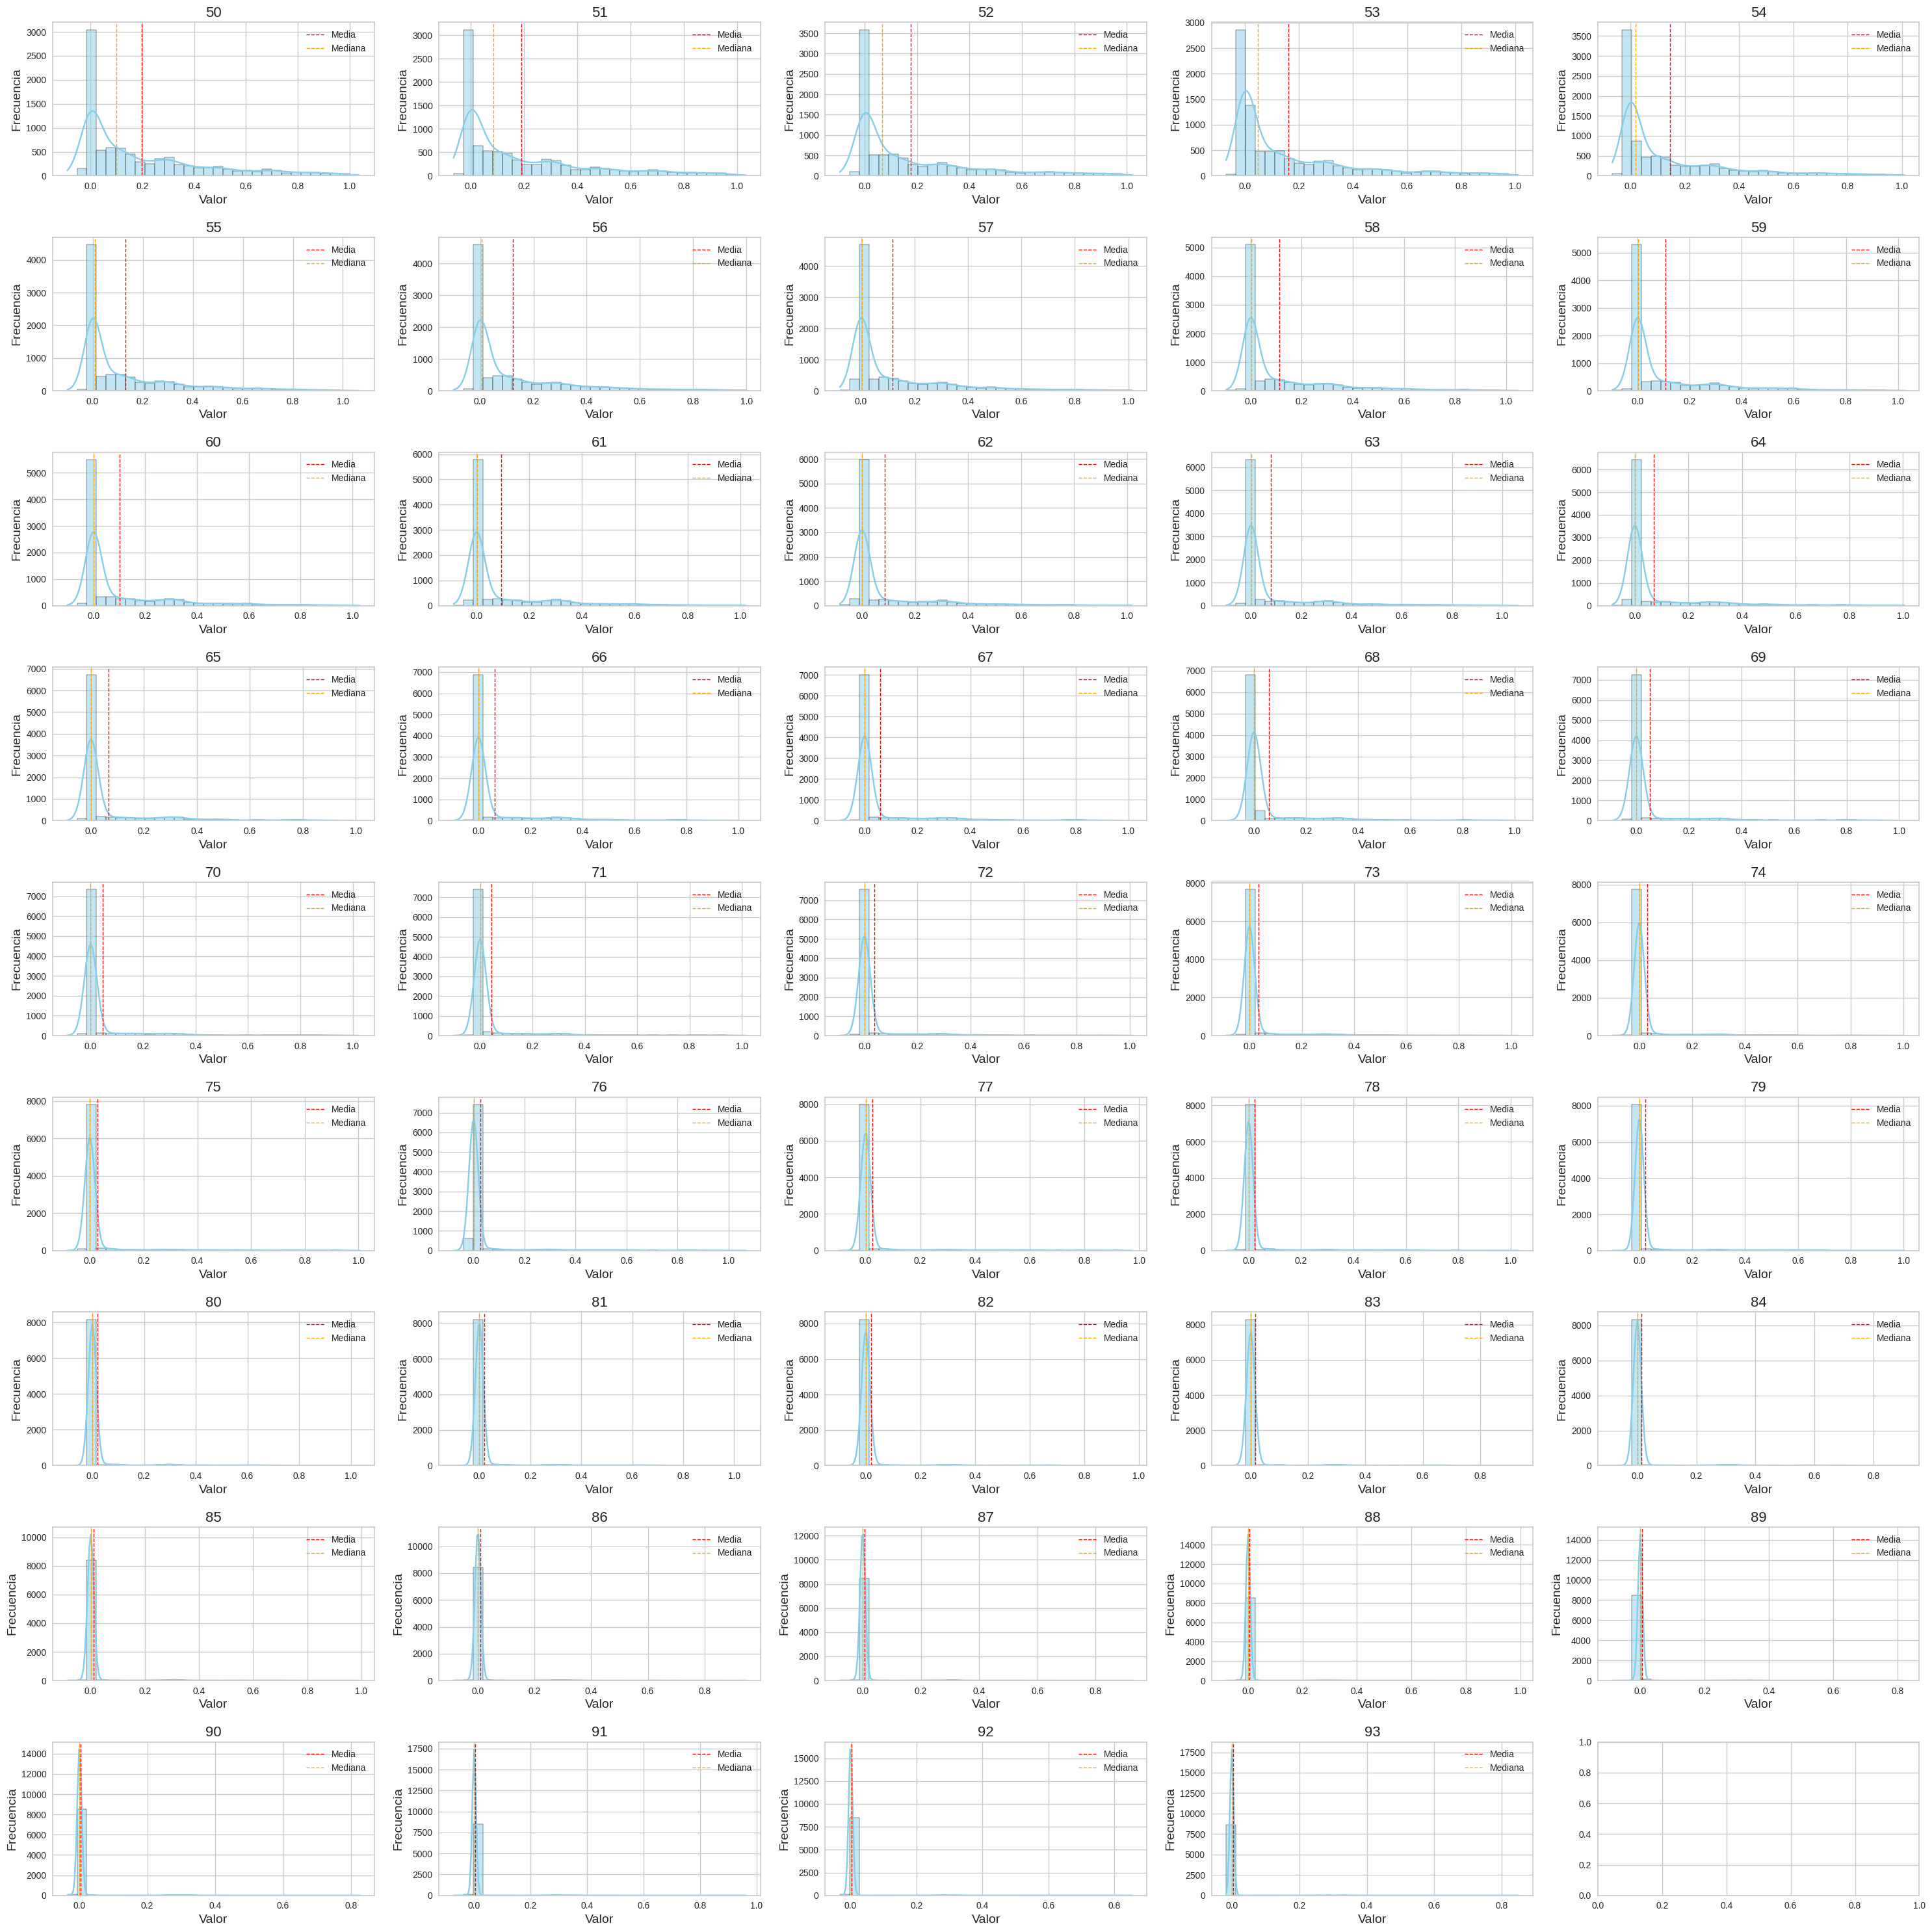

In [11]:
fig, axes = plt.subplots(9, 5, figsize=(30, 30))

MITBIH_data_no_target = MITBIH_data.drop(columns=['target'])
MITBIH_data_tail = MITBIH_data_no_target.iloc[:, 50:]

for i, c in enumerate(MITBIH_data_tail.columns):
    ax = axes.flatten()[i]
    sns.histplot(data=MITBIH_data_tail, x=c, ax=ax, bins=30, kde=True, color='skyblue')
    ax.set_title(c, fontsize=16)
    ax.set_xlabel('Valor', fontsize=14)
    ax.set_ylabel('Frecuencia', fontsize=14)

    mean = MITBIH_data_tail[c].mean()
    median = MITBIH_data_tail[c].median()
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Media')
    ax.axvline(median, color='orange', linestyle='dashed', linewidth=1, label='Mediana')
    ax.legend()

plt.tight_layout();
plt.show();

Vemos como generalmente las variables siguen distribuciones bastante lejos de una gaussiana, vemos como muchas tienen distintas distribuciones que se solapan y la mayoría tienen la cola derecha mucho mas pronunciada que la izquierda.

## Apartado A
Dividid los datos en un conjunto de entrenamiento y otro de test (70 %/30 %), la partición
debe estratificarse (fijad también el estado del generador de números aleatorios para la
reproducibilidad). El conjunto de datos ya está preprocesado de manera que todas las variables estén en el rango 0-1. Haced una visualización de los datos mediante PCA y t-SNE.
¿Se puede ver alguna separabildad entre los datos en la proyección en 2D? Comentad los
resultados

### Division de los datos
Procedemos a continuación a realizar la division de nuestro conjunto de datos en 70% al conjunto de entrenamiento y el 30% restante al conjunto de test.

In [12]:
X = MITBIH_data.loc[:,MITBIH_data.columns != 'target']
y = MITBIH_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

### PCA en 2D
Procedemos ahora a aplicar PCA a nuestro conjunto de datos.

In [13]:
from sklearn.decomposition import PCA
myPCA = PCA().fit(X_train);

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[4.51592900e-01 1.06724605e-01 7.17143912e-02 4.03289265e-02
 2.56377571e-02 2.42082503e-02 2.16874105e-02 2.04065990e-02
 1.88486016e-02 1.68569748e-02 1.58257969e-02 1.41012441e-02
 1.21677478e-02 1.10679177e-02 1.06199380e-02 1.00287226e-02
 8.95637453e-03 8.30075343e-03 7.21985871e-03 6.59492566e-03
 6.33701817e-03 5.75851320e-03 5.58120186e-03 5.16989337e-03
 5.11223967e-03 4.78428553e-03 4.59176432e-03 4.21276906e-03
 4.03971893e-03 3.80354609e-03 3.38220980e-03 3.22852795e-03
 2.98556355e-03 2.76916960e-03 2.57524272e-03 2.49150969e-03
 2.40688401e-03 2.22251378e-03 1.99350092e-03 1.94064295e-03
 1.81167662e-03 1.68452854e-03 1.56114151e-03 1.45959787e-03
 1.35961159e-03 1.31107809e-03 1.14762418e-03 1.09861726e-03
 1.01267624e-03 9.26396047e-04 8.50845605e-04 7.87970854e-04
 7.33646597e-04 6.46546740e-04 5.88906231e-04 5.55590411e-04
 4.79814218e-04 4.22854291e-04 3.97581714e-04 3.69466947e-04
 3.15069148e-04 2.84579407e-04 2.60777958e-04 2.40489632e-04
 1.93228052e-04 1.761187

Como tenemos mas de 90 variables, si aplicamos PCA sin restringir el numero de componentes resultantes que queremos, vemos PCA nos devolverá las mismas componentes que variables.

Procedemos ahora a mostrar el análisis de varianza explicada para ver quantas componentes principales nos hacen falta para cubrir un porcentaje acepatble de varianza explicada

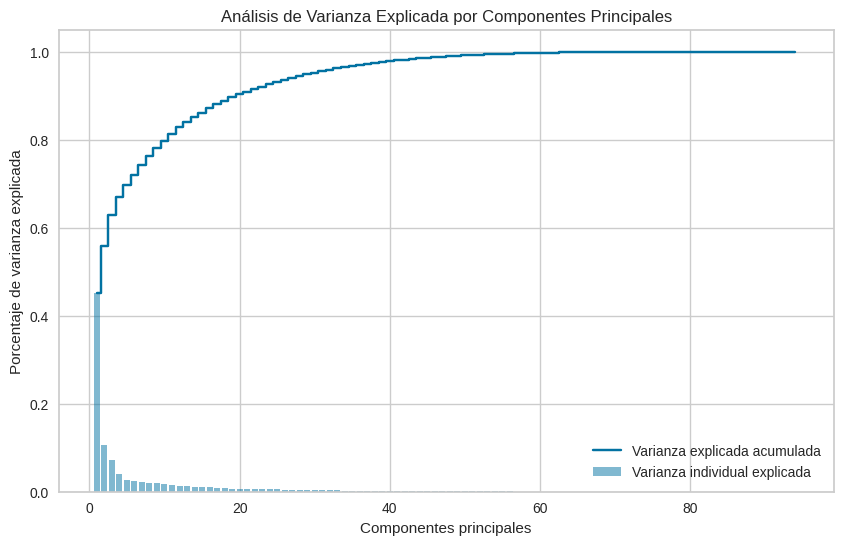

In [14]:
explained_variance = myPCA.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Varianza individual explicada')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Varianza explicada acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Porcentaje de varianza explicada')
plt.legend(loc='best')
plt.title('Análisis de Varianza Explicada por Componentes Principales')
plt.show();

Vemos claramente en el gráfico que a partir de las 20 componentes, la varianza acomulada practicamente no se ve incrementada, vemos como si cojemos las 12 principales componentes ya cubrimos un 80% de toda la varianza de los datos y si cojemos 20 componentes llegamos a un 90% de varianza explicada.

Procedemos ahora a mostrar el gráfico de las cargas de componentes para intentar ver que explican las principales componentes del PCA.
Dado que tenemos un numero de componentes muy elevado, procederemos a mostrar solo las primeras 10 componentes del PCA para poder hacer un análisis con mayor claridad.

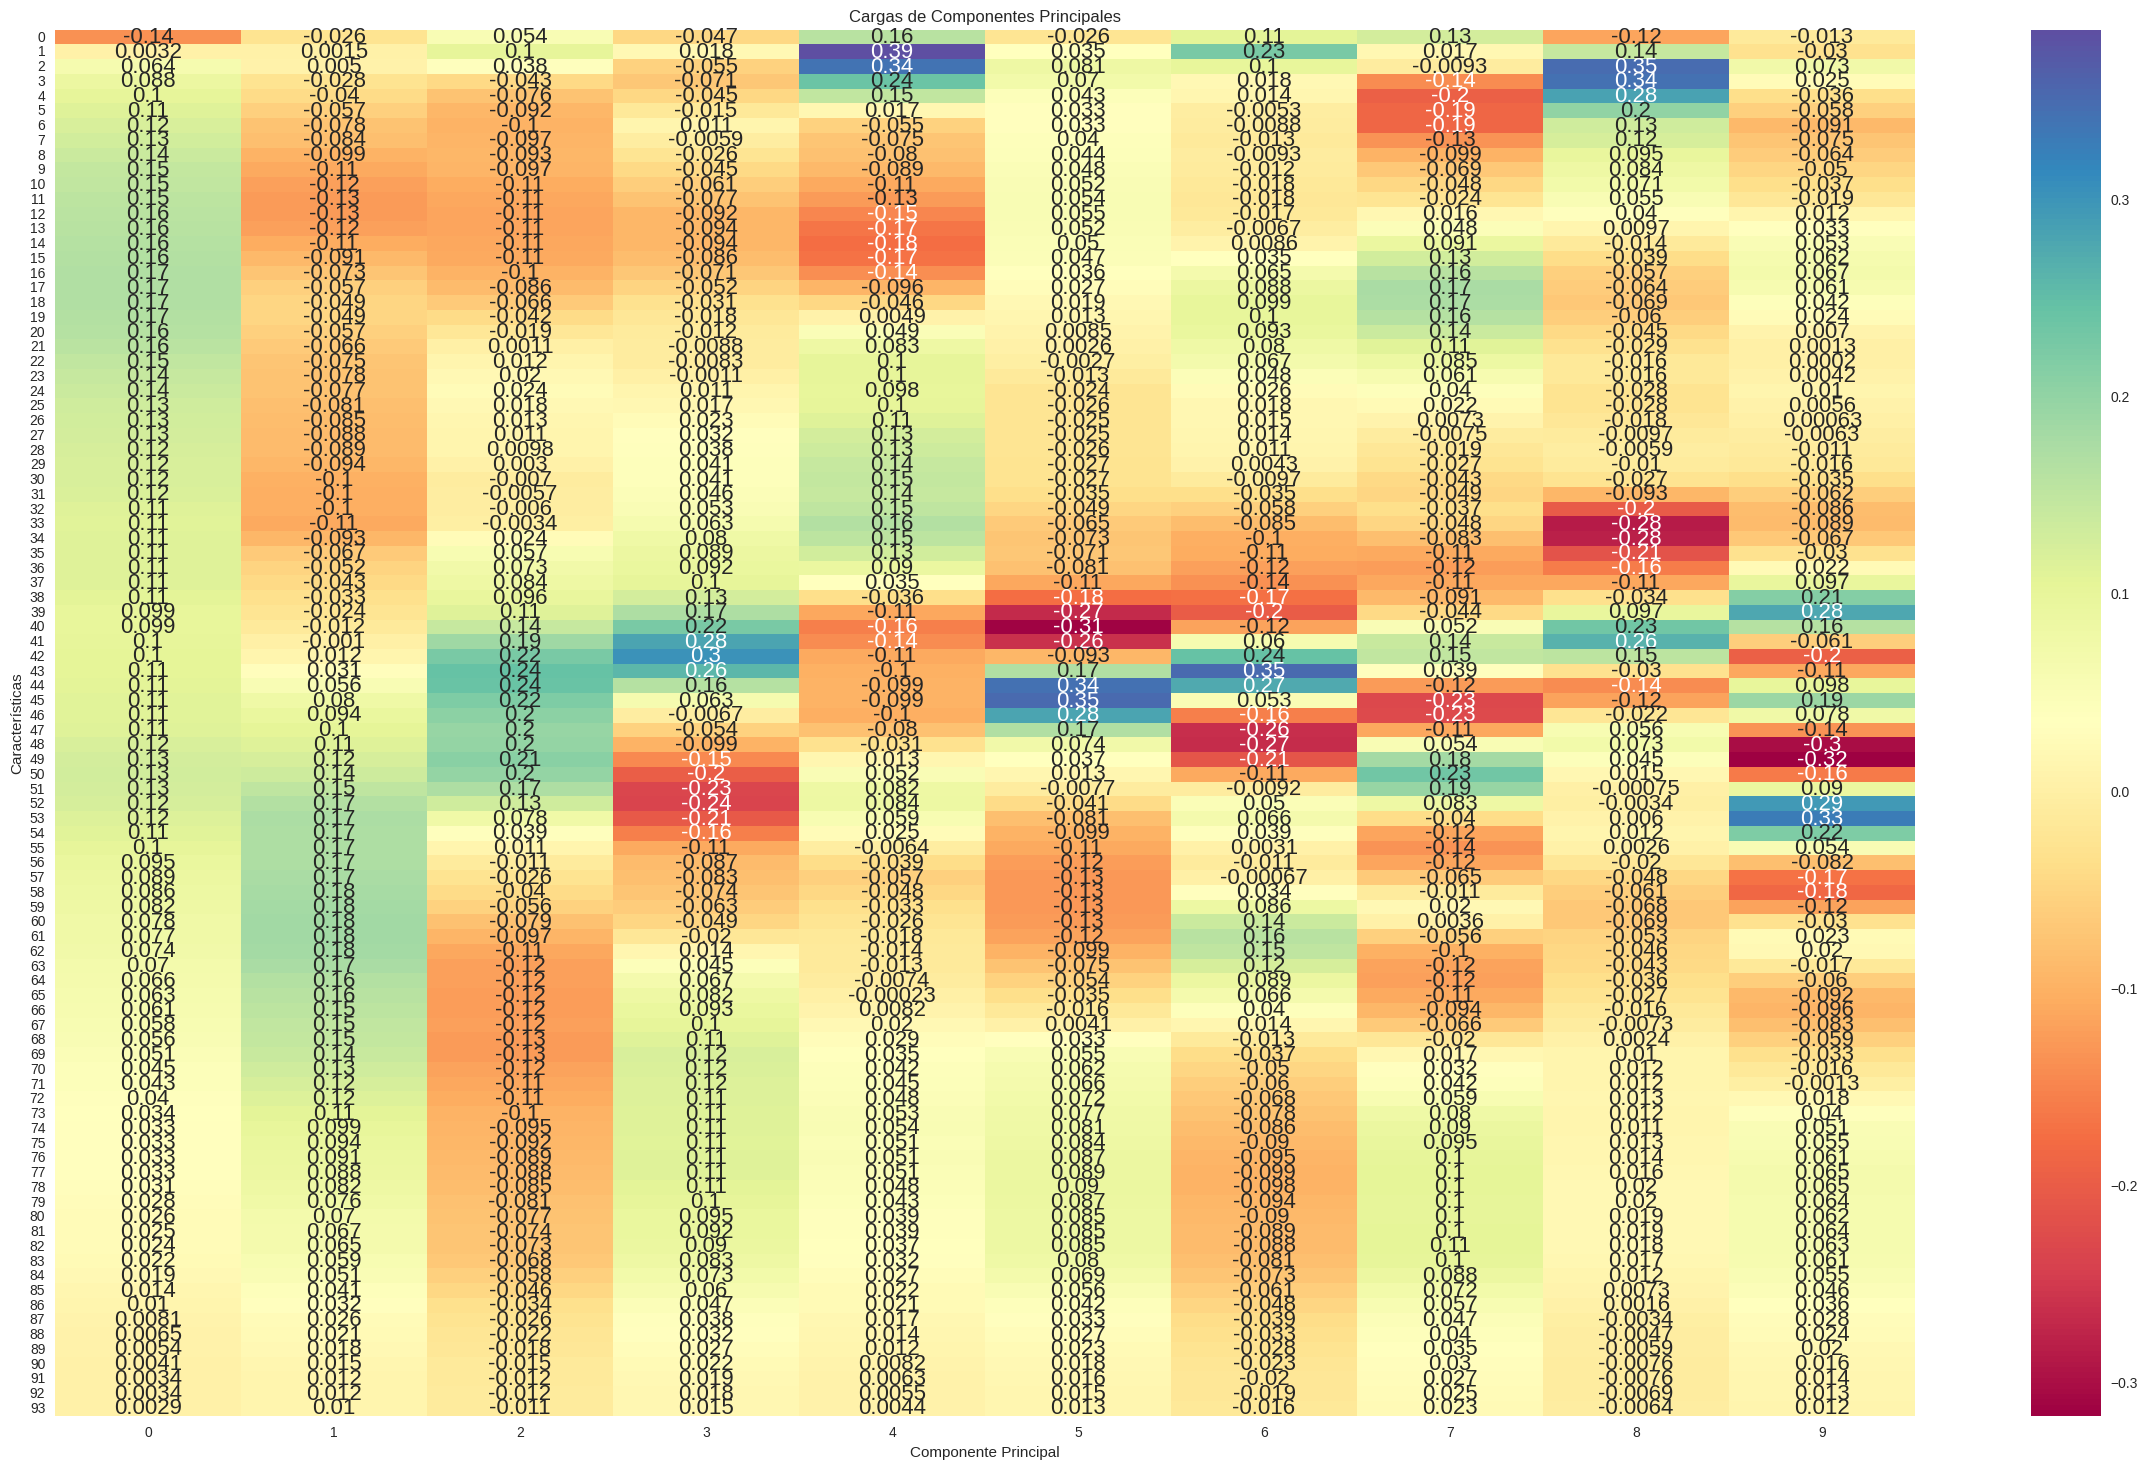

In [15]:
plt.figure(figsize=(30, 18))
components = myPCA.components_[:10]
sns.heatmap(components.T, cmap='Spectral', annot=True)
plt.title('Cargas de Componentes Principales')
plt.xlabel('Componente Principal')
plt.ylabel('Características')
plt.show();

Dado que no tenemos información de que representa cada variable, vemos como:
- la primera componente le da un peso negativo bastante alto a la primera variable y un peso positivo del mismo valor aproximadamente a todas las variables entre 5 y 55.
- la segunda componente le da unas cargas negativas a las variables entre 8-14 y 24-34, y por otra parte da una carga positiva de aproximadamente el mismo valor a las variables comprendidas entre el rango 48-72.
- la cuarta componente ya empieza a dar mas importancia a un numero de variables mas reducido, vemos como las variables 41,42 y 43 tienen una alta carga positiva y por otra parte las variables 51,52 y 53 tienen una alta carga negativa.
- la sexta componente reproduce un poco el comportamiento general de la cuarta componente pero con 6 variables distintas.

Procedemos a continuación a mostrar los resultados del PCA en 2 dimensiones.
Para ello utilizaremos las dos primeras componentes que son las que nos aportan un mayor porcentaje de varianza explicada con el objetivo de obtener la mayor separabilidad posible en los datos.


<Figure size 800x800 with 0 Axes>

<Axes: >

Varianza Explicada por las dos principales componentes:  55.831750505142374 %


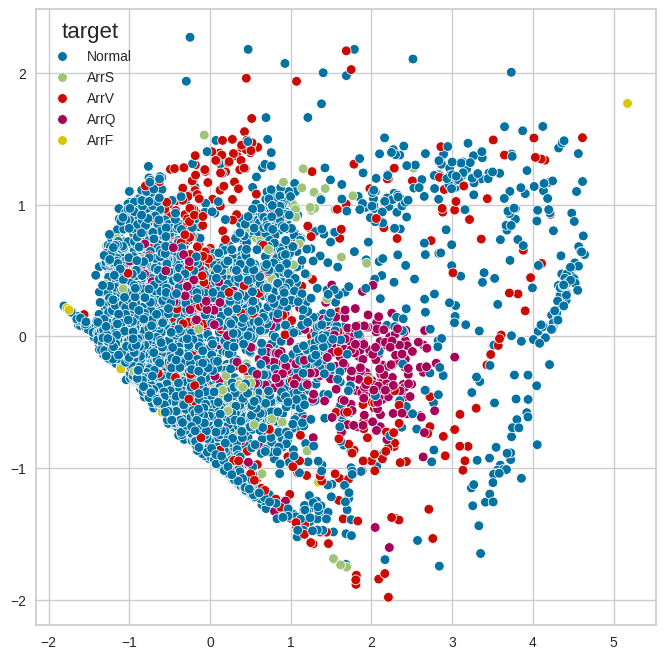

In [16]:
X_trans = myPCA.transform(X_train);
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train);

print("Varianza Explicada por las dos principales componentes: ", (myPCA.explained_variance_ratio_[0] + myPCA.explained_variance_ratio_[1])*100, "%")

Una vez proyectados los datos a las dos principales componentes, como era de esperar dado que las dos principales componentes nos explican un poco mas de la mitad de la varianza total (55%), vemos como no obtenemos una separabiliad que podamos considerar aceptable.

Vemos como hay unos ligeros patrones, las instancias que representan un estado Normal en el cardiograma tienden a acomularse en la zona izquierda del espacio y las instancias que pertenecen a la Arritmia Q y V tienden a acumularse en la zona central del gráfico.


Procedemos ahora a hacer un análisis extra añadiendo la última dimension con la que somos capaces de observar bien los datos con el ojo humano para ver si mejora la situación


In [17]:
import plotly.express as px
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

fig = px.scatter_3d(x=X_trans[:, 0], y=X_trans[:, 1], z=X_trans[:, 2], color=y_train_encoded, color_continuous_scale='Spectral')
fig.show();

Vemos que los resultados obtenidos en el espacio tridimensional no son suficientes ni mucho menos para separar los datos correctamente, así que podemos concluir con que pese a observar ligeros patrones y aglomeraciones de clases no podemos considerar que tengamos una separabilidad aceptable.

### T-SNE en 2D
Visto que con PCA no obtenemos una separabilidad muy aceptable procedemos a aplicar T-SNE dado que es una técnica de reducción de dimensionalidad que se usa especificamente en situaciones donde queremos ver una representacion gráfica de los datos ya sea en 2 o 3 dimensiones.

Como tenemos muchos datos y variables, para encontrar los mejores valores para los hiperparamétros del modelo, no utilizaremos un rango muy elevado dado que el tiempo de ejecución se nos dispará cuadráticamente al hacer las pruebas para cada par de valores de ambos hiperparámetros, así que probaremos con los dos valores de ambos hiperparámetros que suelen dar mejores resultados.

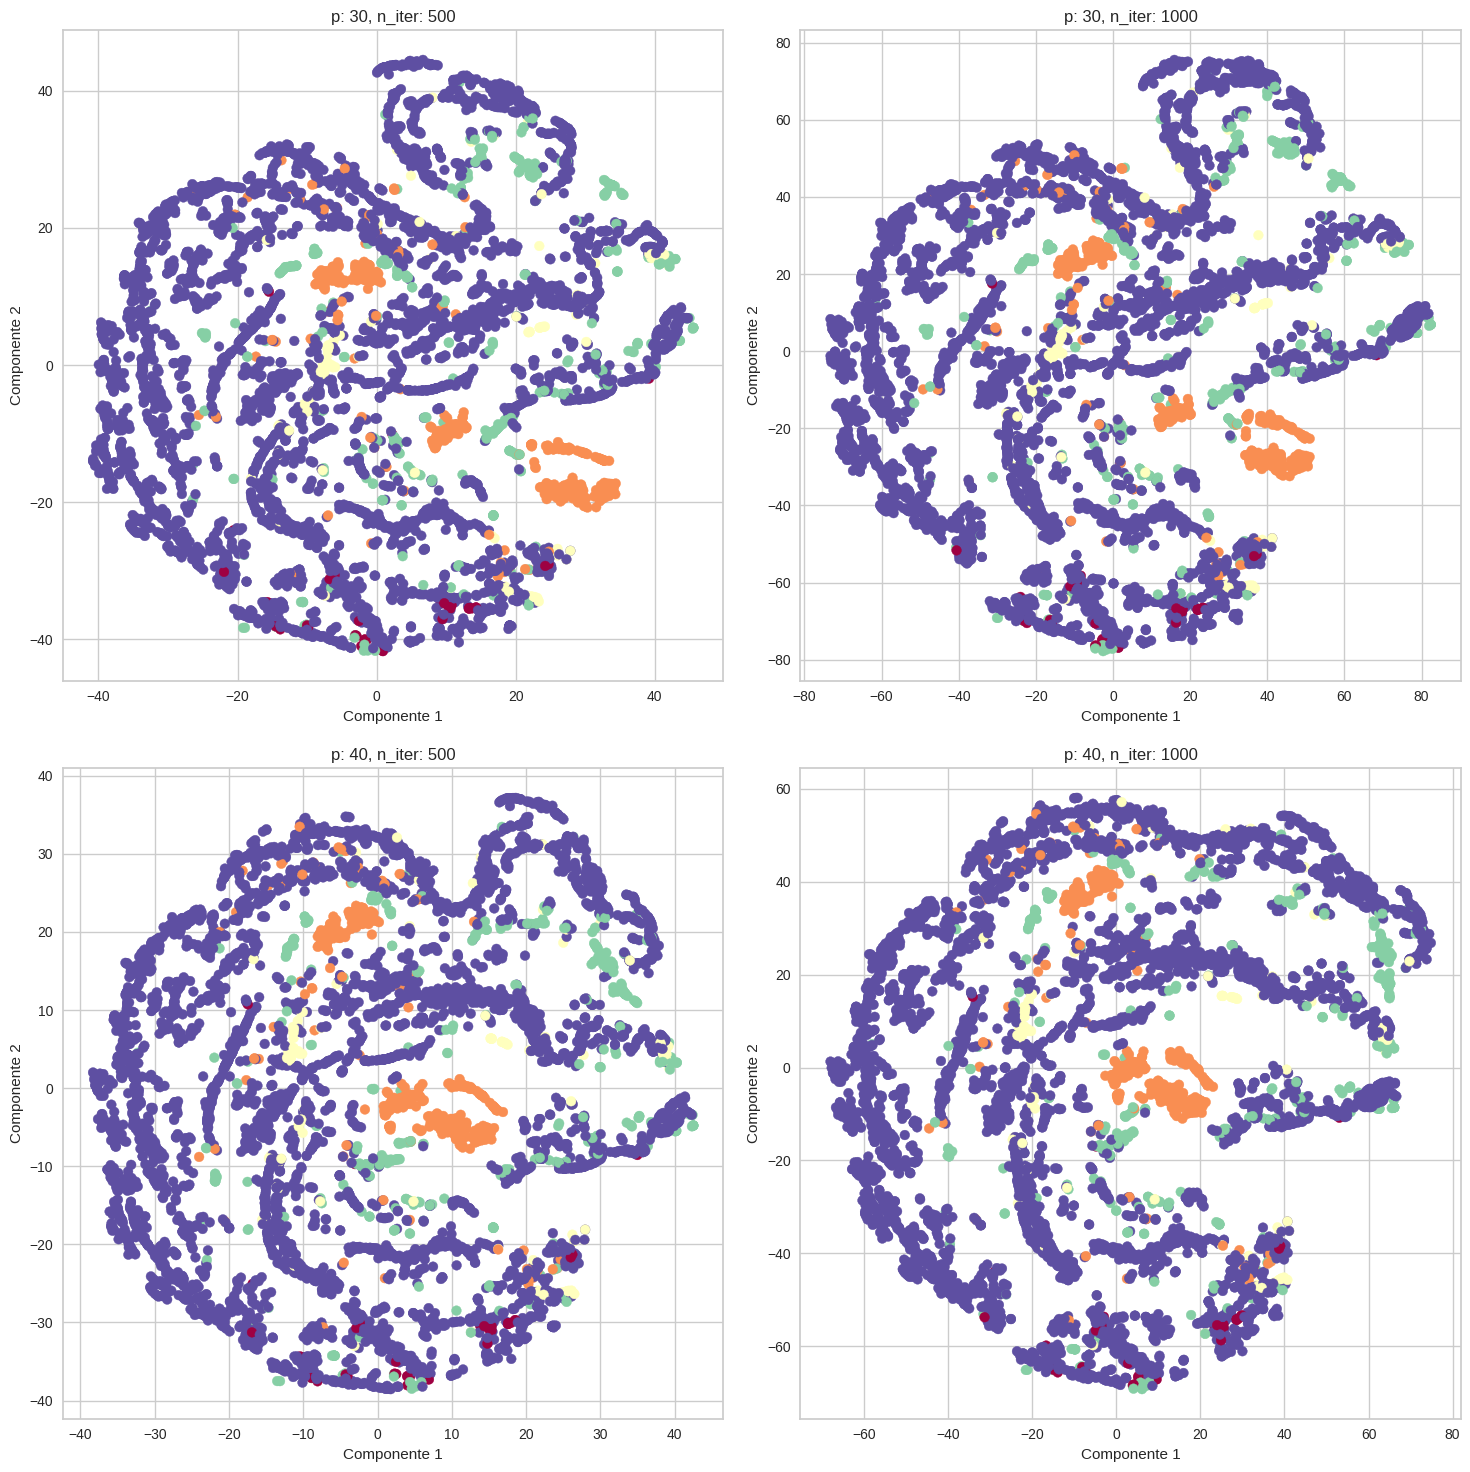

In [18]:
from sklearn.manifold import TSNE

perplexity_values = [30, 40]
n_iter_values = [500, 1000]

fig, axes = plt.subplots(len(perplexity_values), len(n_iter_values), figsize=(15, 15))

for i, perplexity in enumerate(perplexity_values):
    for j, n_iter in enumerate(n_iter_values):

        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
        data_tsne = tsne.fit_transform(X_train)

        ax = axes[i, j]
        ax.scatter(data_tsne[:, 0], data_tsne[:, 1], cmap = 'Spectral', c=y_train_encoded)
        ax.set_xlabel('Componente 1')
        ax.set_ylabel('Componente 2')
        ax.set_title(f'p: {perplexity}, n_iter: {n_iter}')

plt.tight_layout();
plt.show();

Vemos como si cojemos los hiperparámetros de perpejlidad igual a 40 y número de iteraciones igual a 1000 obtenemos los mejores resultados, aunque dejan mucho que desear.

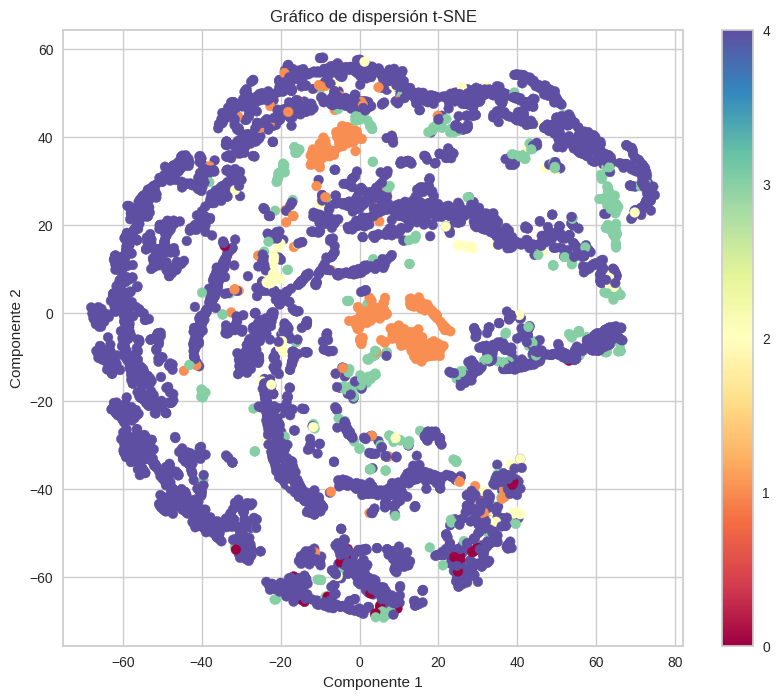

In [19]:
best_perplexity = 40
best_n_iter = 1000

tsne = TSNE(n_components=2, perplexity=best_perplexity, n_iter=best_n_iter, random_state=42)

data_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(10, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], cmap = 'Spectral', c=y_train_encoded)
plt.colorbar(ticks=np.linspace(y_train_encoded.min(), y_train_encoded.max(), 5))
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Gráfico de dispersión t-SNE')
plt.show();

Vemos como si que observamos una ligera separabilidad entre las instancias de la classe de cardigorama Normal y las instancias de la classe de Arritmia V, pero con las demas clases no obtenemos resultados nada esperanzadores.

Probamos tambien ha realizar T-SNE con tres componentes para observar si podemos lograr una separabilidad un poco mayor con la incorporación de una dimensión extra.

In [20]:
tsne = TSNE(n_components=3, perplexity=best_perplexity, n_iter=best_n_iter, random_state=42)

data_tsne = tsne.fit_transform(X_train)

fig = px.scatter_3d(x=data_tsne[:, 0], y=data_tsne[:, 1], z=data_tsne[:, 2], color=y_train_encoded, color_continuous_scale='Spectral')
fig.update_layout(scene=dict(xaxis_title='Componente 1', yaxis_title='Componente 2', zaxis_title='Componente 3'))

Tras aplicar T-SNE con 3 componentes vemos como aun asi no es suficiente para poder separar bien nuestros datos, así que nos movemos al siguiente apartado.

# Apartado B
Asumir que los atributos del conjunto de datos son independientes no es una buena supo-
sición (¿por qué?), pero aun así podemos ajustar un modelo naive Bayes y tomarlo como
resultado base. Comentad los resultados.

Se nos plantea en primer lugar por qué asumir independencia en los atributos no es buena idea.

Si bien esta suposición da lugar a un coste computacional más bajo, no es cierta en la gran mayoría de casos. Naive Bayes estimará
de forma muy deficiente las probabilidades si observamos correlación entre características. Además, no conseguirá captar relaciones
complejas entre variables y favorecerá la clase mayoritaria si los datos están desbalanceados.

Tenemos varias implementaciones de Naive Bayes. Escogeremos la más idonea para nuestro conjunto de datos.

Las versiones disponibles en scikit-learn son las siguientes. Todas siguen el formato "nombre" + "NB" (Naive Bayes):
* GaussianNB: atributos contínuos que siguen una distribución gaussiana.
* BernoulliNB: para atributos binarios (0 o 1). No la podemos usar.
* MultinomialNB: para datos discretos. No puede ser usada para nuestro conjunto de datos.
* ComplementNB: basada en Multinomial pero mejora el rendimiento con clases desbalanceadas. Si bien esta trabajaría mejor para nuestro conjunto de datos, sigue requiriendo de datos discretos, que no tenemos.


La implementación más "idonea" dentro de scikit-learn la encontramos en Naive-Bayes Gaussiano, que nos permite trabajar con valores
continuos. Si bien como ya se ha comentado, nuestros atributos no siguen precisamente una distribución gaussiana.

In [21]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb,X_train,y_train,cv=10))
print(gnb.best_score_)

0.1835830960986896


Como es de esperar, no obtenemos buenos resultados. Naive Bayes no tiene un buen rendimiento con los datos proporcionados.

Un resultado del 20%, teniendo 5 clases nos indica que usar Naive Bayes sería el equivalente a escoger un número aleatorio del 1-5 que nos indicara la clase en la que asociar el dato.

In [22]:
gnb_model = gnb.fit(X_train, y_train)

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=X.columns
means

Priors: [0.00685379 0.07180157 0.02300914 0.06870104 0.82963446]
Means:



0      1      2      3      4      5      6      7      8      9  ...  \
0  0.848  0.568  0.161  0.132  0.137  0.101  0.126  0.097  0.112  0.108  ...   
1  0.852  0.587  0.479  0.364  0.233  0.141  0.119  0.180  0.254  0.305  ...   
2  0.895  0.332  0.088  0.188  0.197  0.190  0.265  0.284  0.299  0.301  ...   
3  0.611  0.519  0.357  0.334  0.320  0.284  0.298  0.300  0.311  0.318  ...   
4  0.901  0.424  0.135  0.178  0.183  0.178  0.212  0.199  0.222  0.223  ...   

          84         85         86         87         88         89  \
0 -1.517e-05  2.103e-04 -4.235e-04  4.246e-04 -3.119e-04  1.717e-04   
1  3.650e-05 -1.874e-05  1.935e-07  1.402e-05 -2.116e-05  2.098e-05   
2  5.358e-02  5.488e-02  5.042e-02  4.854e-02  4.895e-02  4.847e-02   
3  5.048e-02  4.530e-02  3.753e-02  3.145e-02  2.865e-02  2.439e-02   
4  1.270e-02  9.712e-03  7.101e-03  5.472e-03  4.189e-03  3.360e-03   

          90         91         92         93  
0 -3.466e-05 -7.833e-05  1.495e-04 -1.677e-04  
1 -1.526e-05  6.813e-06  1.479e-06 -7.418e-06  
2  5.182e-02  5.151e-02  4.733e-02  5.009e-02  
3  1.973e-02  1.865e-02  1.888e-02  1.530e-02  
4  2.538e-03  1.825e-03  1.595e-03  1.419e-03  

[5 rows x 94 columns]

Vemos que las probabilidades a priori tienen una preferencia muy elevada por una sola clase, en nuestro caso la de los ritmos cardiacos
normales.

In [23]:
print(classification_report(y_test, gnb_model.predict(X_test)))
results_df = save_results(gnb_model, X_test, y_test, 'GNB', results_df)

              precision    recall  f1-score   support

        ArrF       0.00      0.00      0.00        18
        ArrQ       0.09      0.99      0.17       189
        ArrS       0.48      0.25      0.33        61
        ArrV       0.17      0.16      0.17       180
      Normal       0.91      0.12      0.21      2179

    accuracy                           0.19      2627
   macro avg       0.33      0.30      0.17      2627
weighted avg       0.79      0.19      0.20      2627



Observamos que la precisión es únicamente alta en la clase de ritmo cardíaco normal, pero a su vez tiene el valor de sensibilidad
(recall) más bajo. Esto nos indica que mediante GaussianNB, debido al desbalance de datos, si bien acierta en la clasificación correcta
de elementos de la clase Normal, confunde muchos datos de la clase Normal con datos de otras clases.

Otras clases, como ArrF o ArrQ, nos muestran de forma inversa el problema de este modelo: debido a que tenemos pocos datos positivos de
estas clases (la mayoría son de ritmos normales), es muy fácil que un dato considerado de estas clases sea en realidad un falso positivo ya
que pertenezca la clase Normal (precisión baja), y a su vez, al tener tan pocos datos, es dificl que lo clasifiquemos en la clase normal y
que en realidad perteneza a ArrF/ArrQ (sensibilidad alta).

Mediante la matriz de confusión podemos observar estos resultados más claramente:

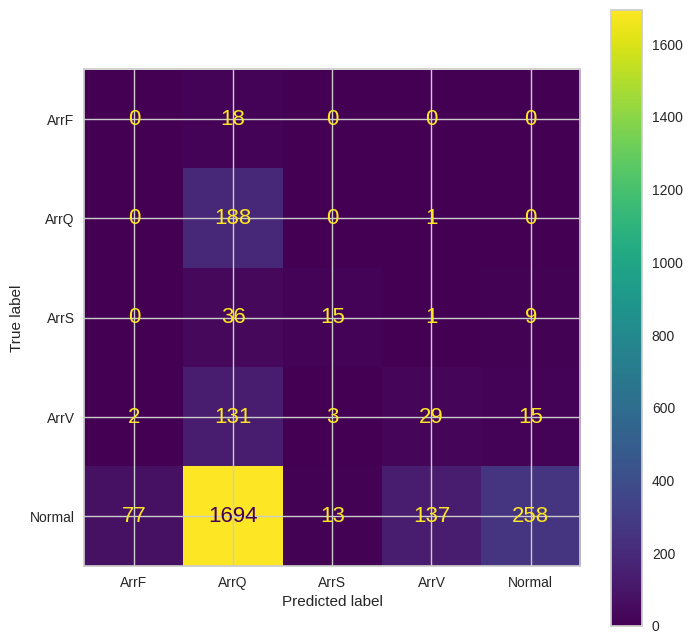

In [24]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test,y_test, ax=plt.subplot());

Vemos que el problema principal de nuestros datos es que gaussianNB intenta encontrar una distribución más o menos gaussiana de nuestros datos,
pero al tener datos tan desbalanceados, este intento de clasificación lleva a enormes errores debido a que el modelo no es capaz de captar que
la gran mayoría de datos son de ritmos normales, y no están bien distribuidos.

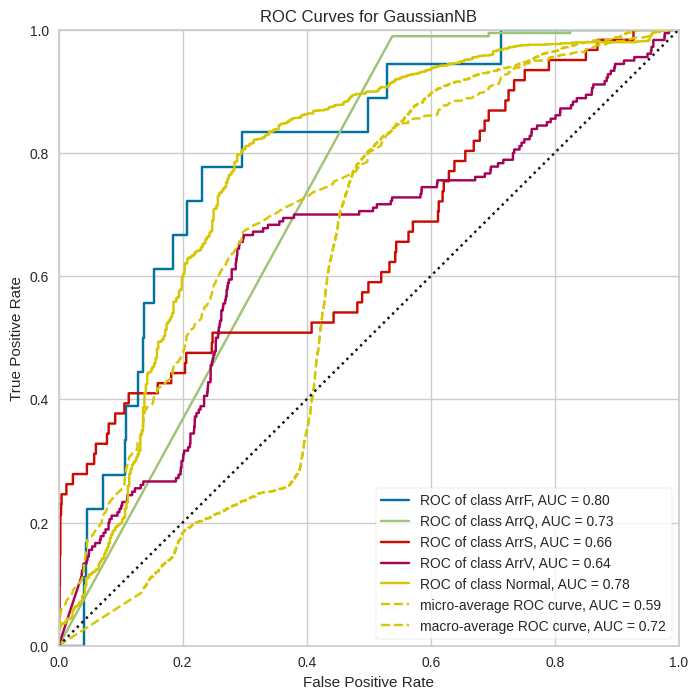

In [25]:
from yellowbrick.classifier.rocauc import roc_auc

plt.figure(figsize=(8,8));
roc_auc(gnb_model, X_train, y_train, X_test, y_test, classes=['ArrF', 'ArrQ', 'ArrS', 'ArrV', 'Normal']);

## Apartado C

Ajustad un modelo discriminante lineal y una regresión logística con penalización L2 usando como optimizador `lbfgs`. Ajustad adecuadamente los hiperparámetros de estos modelos a los datos y determinad la calidad de los mejores modelos. Comentad los resultados

#### LDA

Procedemos a continuacion a clasificar los ejemplos usando el discriminante lineal sobre los datos de entrenamiento


LDA intenta modelar la probabilidad $p(y=C_k|X=x)$ asumiendo:
* $p(x|C_k)$ es Gaussiano (lo que significa que puede ser descrito por $\mu_k$ y $\Sigma_k$)
* Todas las matrices de covarianza son iguales ($\Sigma_k = \Sigma$)

Aplicando maxima verosimilitud y todas estas suposiciones, obtenemos la siguiente función discriminante:

$a_k(x) = x^T\Sigma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + log(\pi_k)$

Donde $\pi_k$ son las probabilidades a priori de las clases.

Si llamamos:

$w = \Sigma^{-1}\mu_k$

$w_0=- \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + log(\pi_k)$

Obtenemos una representación lineal de la fórmula.



In [26]:
lda = LinearDiscriminantAnalysis()

param = {'solver': ['svd', 'lsqr', 'eigen']}
lda_gs = GridSearchCV(lda, param, cv=10, n_jobs=-1, refit=True)

lda_gs.fit(X_train, y_train);

Vemos con que solver obtenemos una mejor solucion

In [27]:
show_html(pd.DataFrame(lda_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Vemos que con todos obtenemos los mismos resultados asi que nos quedamos con el modelo con singular vaule descomposition que es el que utiliza el solver por defecto.

Pasamos a continuación a ver los pesos que asigna LDA a cada variable

<Figure size 1800x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Coeficientes más importantes para la clase ArrF')

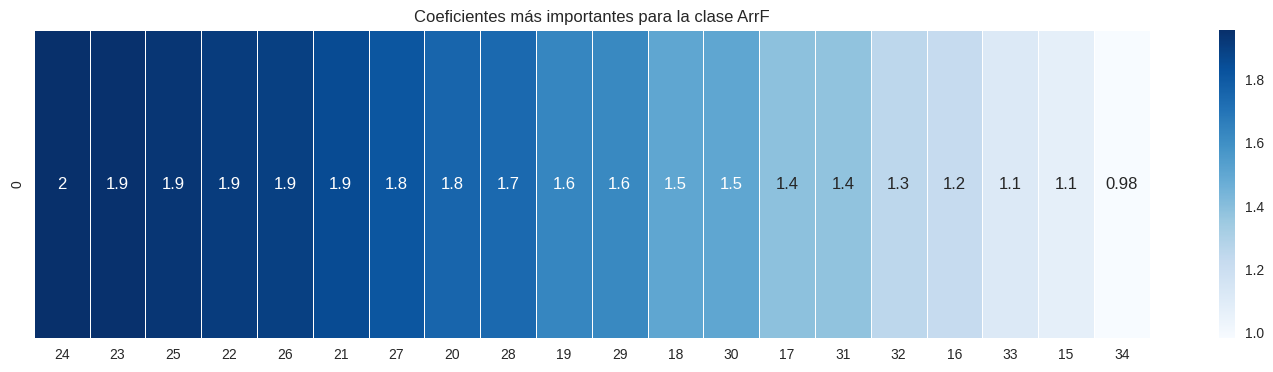

<Figure size 1800x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Coeficientes más importantes para la clase ArrQ')

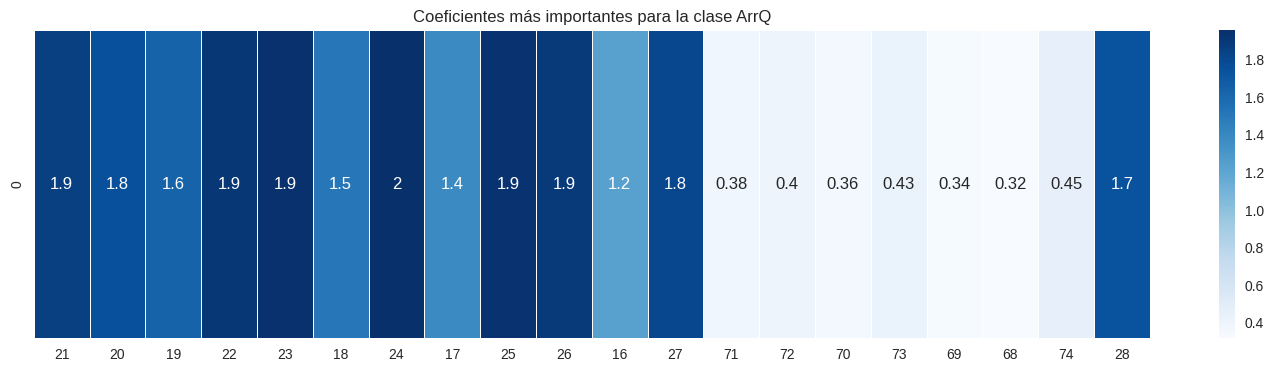

<Figure size 1800x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Coeficientes más importantes para la clase ArrS')

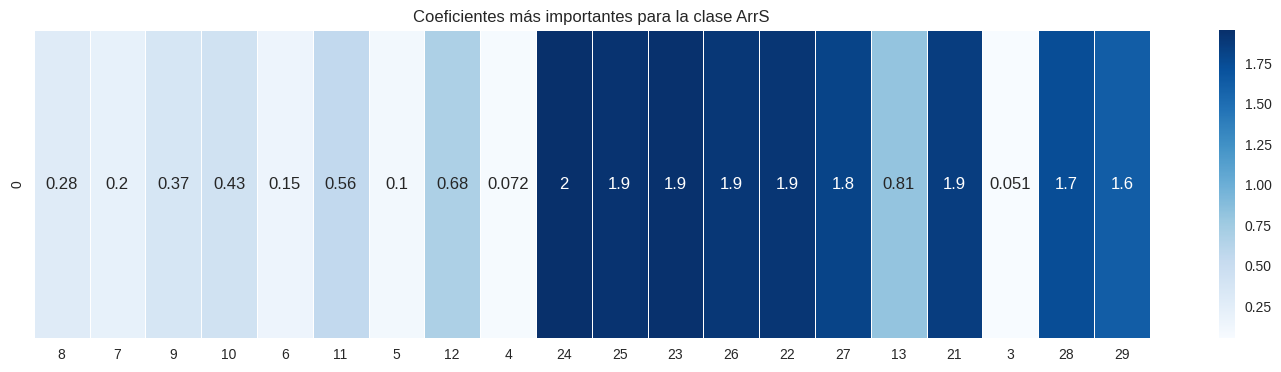

<Figure size 1800x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Coeficientes más importantes para la clase ArrV')

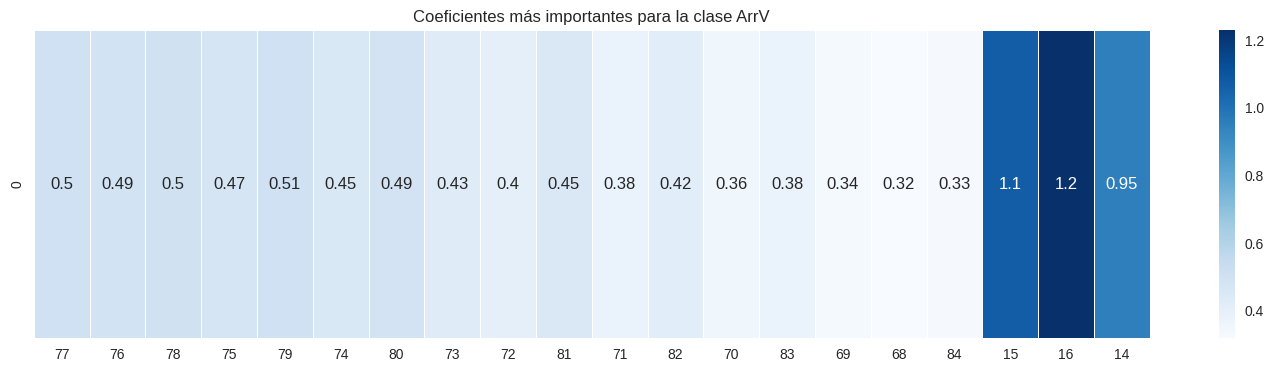

<Figure size 1800x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Coeficientes más importantes para la clase Normal')

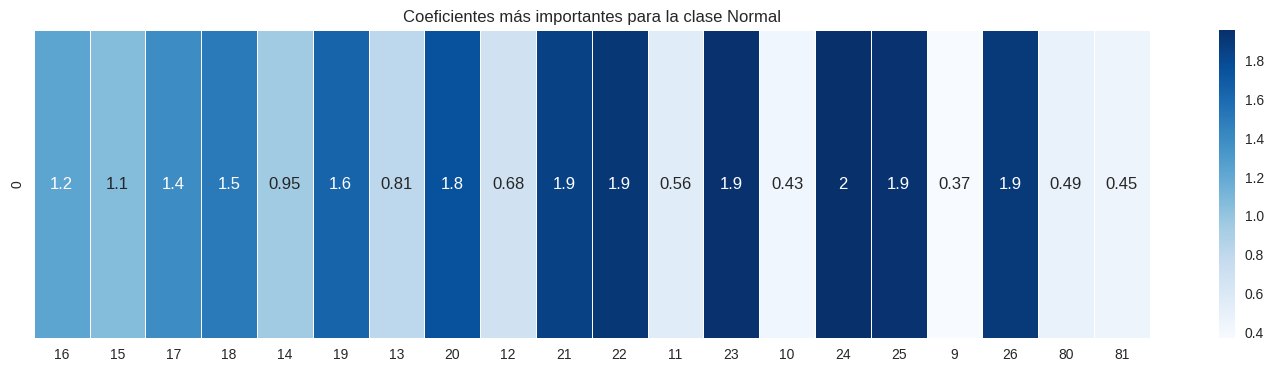

In [28]:
coefs = pd.DataFrame(lda_gs.best_estimator_.coef_)
coefs.columns = X_train.columns

n_most_important = 20

for i in range(coefs.shape[0]):
    important_coefs = coefs.abs().T.nlargest(n_most_important, coefs.index[i])
    coef_clase_i = important_coefs.drop(important_coefs.columns[1:], axis=1)

    plt.figure(figsize=(18, 4))
    sns.heatmap(coef_clase_i.T * 0.001, annot=True, linewidths=.5, cbar=True, xticklabels=True, cmap='Blues', annot_kws={'size': 12})
    plt.title(f'Coeficientes más importantes para la clase {lda_gs.best_estimator_.classes_[i]}')
    plt.show();
    plt.close('all')

Vemos como en general, las columnas que mayor peso tienen en el modelo se enuenctran en todas las clases entre las columnas 10 y 30.

In [29]:
print(classification_report(y_test, lda_gs.best_estimator_.predict(X_test), target_names=['ArrF', 'ArrQ', 'ArrS', 'ArrV', 'Normal']))
results_df = save_results(lda_gs.best_estimator_, X_test, y_test, 'LDA', results_df)

              precision    recall  f1-score   support

        ArrF       0.12      0.33      0.17        18
        ArrQ       0.93      0.87      0.90       189
        ArrS       0.39      0.34      0.37        61
        ArrV       0.41      0.38      0.39       180
      Normal       0.93      0.93      0.93      2179

    accuracy                           0.87      2627
   macro avg       0.56      0.57      0.55      2627
weighted avg       0.88      0.87      0.87      2627



Pasamos a continuacion a mostrar la matriz de confusion del LDA

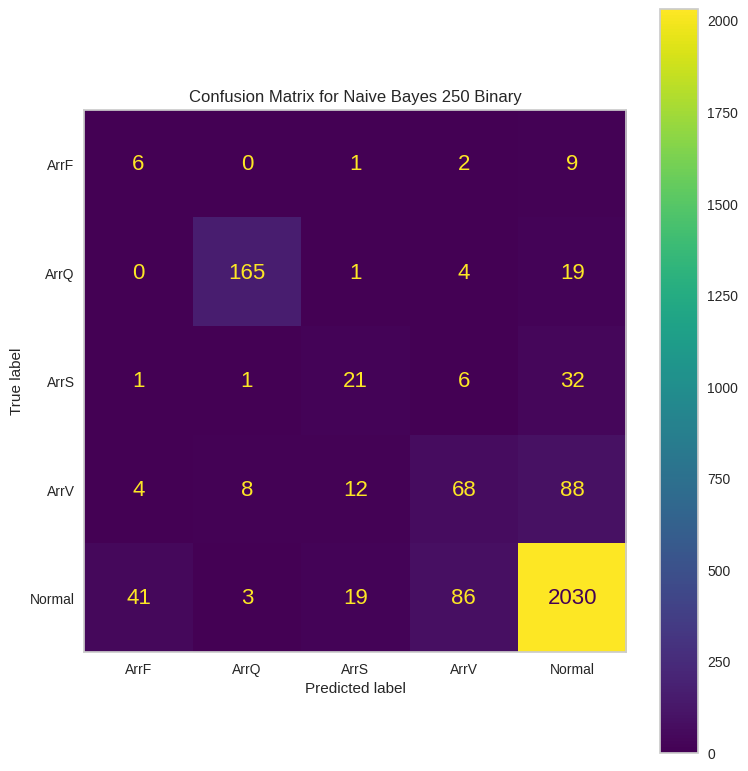

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.grid(False)
ConfusionMatrixDisplay.from_estimator(lda_gs.best_estimator_, X_test, y_test, ax=plt.subplot());

plt.title('Confusion Matrix for Naive Bayes 250 Binary')
plt.tight_layout()
plt.show();

Vemos como claramente la que mejor resultados obtiene es la classe mayoritaria, seguida del tipo de arritmiaQ que obtiene unos valores muy buenos tambien y en tercer lugar ya tenemos los tres otros tipos de arritmia en los que observamos como de mal se comporta el modelo.

Vemos como la mayoria de tipos de arritmia se confunden con NO tener arritmia en especial en las que tenemos menos datos ArrS y ArrF, aunque en el caso de ArrV que tenemos mas o menos la misma cantidad de datos que la ArrQ vemos como tambien classificamos mas valores erroneos que correctos.


Para clasificadores probabilísticos podemos también decidir cual la probabilidad de decisión que utilizaremos para determinar la clasificación de un ejemplo en una clase u otra.

Las consecuencias de elegir una probabilidad u otra la podemos representar en la **curva ROC** (Receiver Operating Characteristic curve) que representa la tasa de verdaderos positivos contra la de falsos positivos para diferentes puntos de corte. Sobre esta curva se calcula el **AUC** (area under the curve) que será 1 en el caso de un clasificador sin errores.

Lo que nos interesaría es un clasificador con predicción perfecta de manera que la tasa de verdaderos positivos sea 1 y la de falsos positivos sea 0. Podemos ver en la curva que punto corresponde a una tasa alta de verdaderos positivos con una tasa baja de falsos positivos.

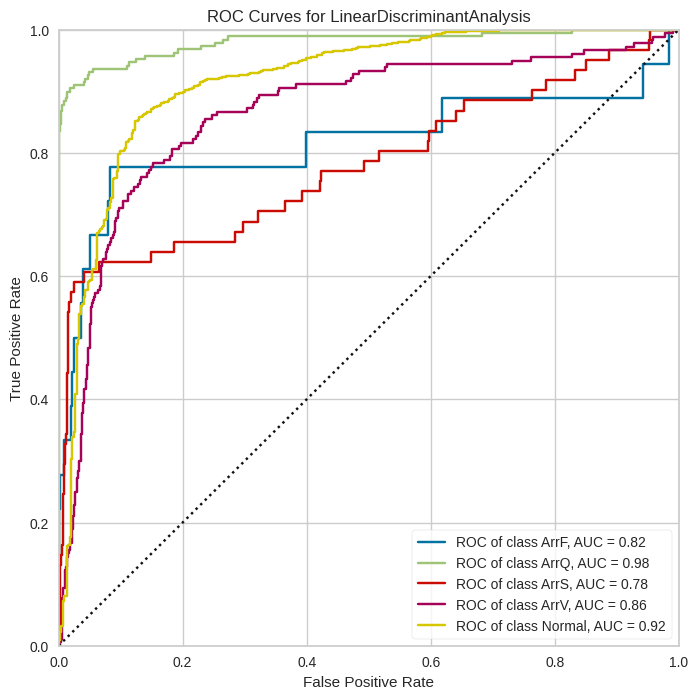

In [31]:
plt.figure(figsize=(8,8));
roc_auc(lda_gs.best_estimator_, X_train, y_train, X_test, y_test, classes=['ArrF', 'ArrQ', 'ArrS', 'ArrV', 'Normal'], micro=False, macro=False);

Vemos como en la que obtenemos mejores resultados a pesar de tener muchísimos datos menos que la clase Normal, es en la clase de arritmia de tipo Q.
En las demas clases observamos ya que elegir un threshold en concreto nos resulta mas difícil dado que cada clase tiene una forma y comportamiento distinto y lo que ganariamos en una clase lo perderiamos en otra.

#### Regresión logística

Vamos a ajustar una regresión logística con penalización L2, usando como optimizador lbfgs. Sabemos que la regresión logística estima directamente  $p(y=C_k|X=x)$ evitando el tener que asumir una distribución específica para los atributos de las clases. En este modelo tenemos pesos para la función lineal, pero son diferentes de los que tenemos en LDA, ya que representamos la distribución de forma distinta.


La implementación de scikit-learn de la regresión logística nos permite aplicar regularización igual que en regresión lineal, y usaremos una penalización de los pesos usando L2, tal y como indica el enunciado.

In [32]:
# La regularización L2 y el solver lbgfgs se usan por defecto, pero es mejor especificarlo para que quede claro
lr = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)

# Ajustamos el parametro C que controla la importancia de la regularizacion, usando GridSearch
param = {'C': 10**np.linspace(-3, 3, 21, endpoint=True)}
lr_gs = GridSearchCV(lr, param, cv=10, n_jobs=-1, refit=True)

# Ajustamos el modelo
lr_gs.fit(X_train, y_train);

In [33]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Podemos ver que hay dos valores de C que nos dan el mismo mejor resultado, optamos en este caso por elegir cualquiera de los dos. A continuación podemos ver algunos pesos (los mas importantes, ya que tenemos muchos atributos.

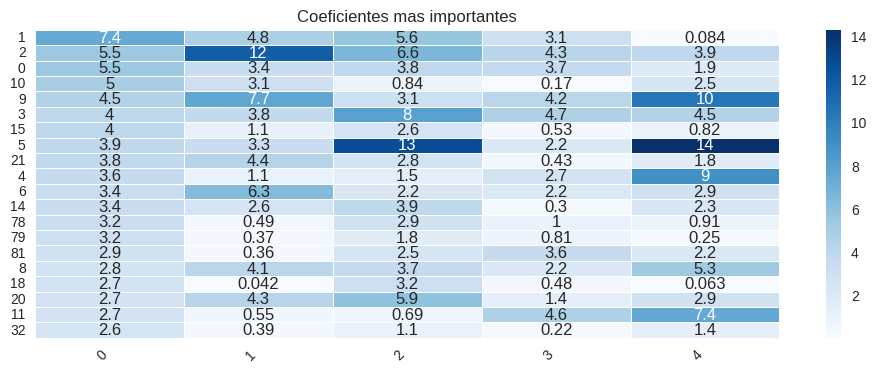

In [34]:
# Obtenemos los coeficientes del mejor estimador
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X.columns

# Visualizamos solo los coeficientes más importantes
n_most_important = 20

important_coefs = coefs.abs().T.nlargest(n_most_important, coefs.index[0])

# Heatmap de los pesos mas import.
plt.figure(figsize=(12, 4))
sns.heatmap(important_coefs, annot=True, linewidths=.5, cbar=True, xticklabels=True, cmap='Blues', annot_kws={'size': 12})
plt.title('Coeficientes mas importantes')
plt.xticks(rotation=45, ha='right')
plt.show();

Dado que los atributos no estan etiquetados con numeros, no podemos sacar grandes conclusiones de estos pesos, mas allá de ver que hay variables con pesos muy superiores a las demás. A continuaciónn podemos ver el resultado del modelo, viendo su rendimiento en la partición de test.

In [35]:
# Generamos el reporte de clasificación usando classification report
print(classification_report(y_test, lr_gs.predict(X_test)))

# Guardar resultados (para mostrar un resumen al final del ejercicio)
results_df = save_results(lr_gs, X_test, y_test, 'Logistic', results_df)

              precision    recall  f1-score   support

        ArrF       0.67      0.22      0.33        18
        ArrQ       0.93      0.90      0.91       189
        ArrS       0.56      0.39      0.46        61
        ArrV       0.52      0.24      0.33       180
      Normal       0.92      0.98      0.95      2179

    accuracy                           0.90      2627
   macro avg       0.72      0.55      0.60      2627
weighted avg       0.88      0.90      0.89      2627



Vemos en los resultados que el modelo no es muy bueno. Pese a que es bastante bueno en precisión y recall de la classe mayoritaria (Normal) y en la clase ArrQ, en las demas clases es muy malo. Esto puede ser debido a que, debido a que tenemos muchos mas ejemplos de la clase normal, el modelo puede estar enfocandose en minimizar la pérdida en la clase mayoritaria en lugar de aprender a distinguir entre las clases minoritarias. Viendo esto, puede que sea buena idea usar otros modelos, o bien usar un modelo para separar arritmia de normal, y luego otro modelo para especificar el tipo de arritmia (lo hacemos en un apartado posterior)

A continuación podemos ver la matriz de confusión. Se corrobora lo visto en los resultados previos, el modelo es muy bueno prediciendo la clase normal, pero en general muy malo con las arritmias.

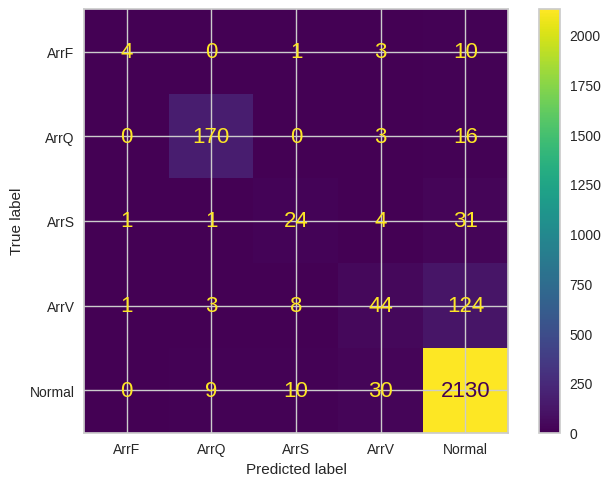

In [36]:
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test,y_test, ax=plt.subplot());

## Apartado D

La regresión logística tiene un parámetro class_weight que permite cambiar el peso del
error que tienen las diferentes clases. En este caso nos importa menos el error que se comete
en la clase normal. Tenemos la opción de usar el valor balanced que calcula el peso de las
clases a partir del inverso de su frecuencia. Ajustad de nuevo este modelo de esta manera.
Comentad los resultados y comparad el modelo con los otros. Se puede asignar también
un peso específico por clase. Explorad un poco los pesos de las clases para ver si obtenéis
un mejor resultado, considerando que es mejor clasificar más ejemplos de arritmias.

Lo que sugiere el enunciado podria solucionar el problema con el que nos hemos encontrado en el apartado anterior. La clase mayoritaria (Normal) tiene demasiado importancia en el cálculo del error, por lo que debemos hacer que dicha clase tenga menos peso. Vamos a volver a ajustar la regresión logística, primero usando como peso el valor balanced.

In [37]:
# Ahora usando también balanced
lr = LogisticRegression(penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=10000)

# Ajustamos el parametro C que controla la importancia de la regularizacion, usando GridSearch
param = {'C': 10**np.linspace(-3, 3, 21, endpoint=True)}
lr_gs = GridSearchCV(lr, param, cv=10, n_jobs=-1, refit=True)

# Ajustamos el modelo
lr_gs.fit(X_train, y_train);

In [38]:
print(classification_report(y_test, lr_gs.predict(X_test)))

results_df = save_results(lr_gs, X_test, y_test, 'Logistic_balanced', results_df)

              precision    recall  f1-score   support

        ArrF       0.06      0.56      0.11        18
        ArrQ       0.70      0.92      0.79       189
        ArrS       0.14      0.66      0.23        61
        ArrV       0.31      0.74      0.44       180
      Normal       0.97      0.67      0.79      2179

    accuracy                           0.69      2627
   macro avg       0.44      0.71      0.47      2627
weighted avg       0.88      0.69      0.75      2627



Podemos ver que el balanceo de pesos ha tenido cierto impacto en el resultado del modelo, sobretodo en el **recall**.  En cuanto a las precisiones (verdaderos positivos respecto a los clasificados como positivos), vemos como en la clase normal mejora un poco, pero en las clases de arritmia en general ha disminuido de forma considerable. Por otro lado, el recall (verdaderos positivos respecto a los positivos) ha mejorado bastante en las clases de arritmia, pero ha empeorado en la classe Normal. Lo que ha sucedido en las clases de arritmia con este cambio es:
- Antes, sobre los ejemplos que se clasificaban como positivos una porción x eran verdaderos positivos, y ahora esa porción es menor. Por lo tanto, del total de positivos que predice nuestro modelo una proporción menor son verdaderos positivos.

- Antes, sobre los ejemplos positivos (clase real) una porcion x eran verdaderos positivos predecidos por nuestro modelo, y ahora esa porción es mayor. Por lo tanto del total de positivos predecimos mas.

Los resultados tienen sentido, mejoramos en recall pero eso implica que al recuperar mas la precisión disminuye.

Tal y como sugiere el enunciado, a continuación vamos a probar de asignar un peso específico por clase. Se nos dice que es mejor clasificar más ejemplos de arritmias, así que nuestro objetivo entonces es maximizar el recall en las arritmias.

In [39]:
# Definimos los pesos específicos para cada clase
class_weights = {
    'ArrF': 30,
    'ArrQ': 30,
    'ArrS': 30,
    'ArrV': 30,
    'Normal': 0.1,   # El peso menor es para la clase mayoritaria
}

lr = LogisticRegression(penalty='l2', solver='lbfgs', class_weight=class_weights, max_iter=10000)

param = {'C': 10**np.linspace(-3, 3, 21, endpoint=True)}
lr_gs = GridSearchCV(lr, param, cv=10, n_jobs=-1, refit=True)

lr_gs.fit(X_train, y_train);

In [40]:
print(classification_report(y_test, lr_gs.predict(X_test)))

              precision    recall  f1-score   support

        ArrF       0.04      0.50      0.08        18
        ArrQ       0.43      0.96      0.60       189
        ArrS       0.06      0.77      0.10        61
        ArrV       0.24      0.81      0.37       180
      Normal       0.99      0.25      0.40      2179

    accuracy                           0.35      2627
   macro avg       0.35      0.66      0.31      2627
weighted avg       0.87      0.35      0.40      2627



Después de haber probado varias combinaciones, vemos que hay un trade-off entre recall y precisión. Aunque mejoremos el recall de las clases de arritmia (que es nuestro objetivo) perdemos precisión. Es decir, predecimos mas ejemplos de arritmia del total, pero del total de arritmias concretas que predecimos un pequeña porción son verdaderos positivos. Predecimos mas, pero con menos precision. Esto nos lleva a una conclusión parecida a la de antes, a lo mejor afrontar este problema con este modelo no es lo ideal, y deberemos buscar soluciones alternativas.

## Apartado E

Ajustad un modelo k-vecinos cercanos a los datos explorando adecuadamente sus parámetros. Evaluad la calidad del modelo y comparadlo con los otros.

El modelo K-vecinos asume que tenemos fronteras complejas entre las clases que se pueden aproximar de manera local. Como se nos explica en el laboratorio, este modelo funciona bien para conjuntos con muchos datos (que parece ser nuestro caso). Por otro lado el modelo se beneficia si los datos tienen todos la misma escala para no dar mayor importancia a una dimension que a otra a la hora de calcular las distancias.

In [41]:
# normalizamos los valores para que todos tengan la misma importancia
mMScaler = MinMaxScaler()
X_train_s = mMScaler.fit_transform(X_train)
X_test_s = mMScaler.transform(X_test)

Se nos pide explorar adecuadamente los parametros del modelo. En el caso de los k-Vecinos, los parametros de los que hablamos son:
- El numero de vecinos (*K*)
- La función de distancia (*metric*)
- La función de estimación de las k-classes (*weigths*)

Para lograr una exploración concienzuda usaremos la exploración en rejilla (*gridsearch*). \\
La función de estimación acepta por defecto los valores *uniform*, donde todos los vecinos tienen la misma importancia, y *distance*, en donde los vecinos mas cercanos tienen mayor peso. \\
KNeighborsClassifier nos ofrece un conjunto de funciones de distancia a usar:
- cityblock
- cosine
- euclidean
- l1
- l2
- haversine
- manhattan
- nan-euclidean

In [42]:
knn =  KNeighborsClassifier()

# Ajustamos el modelo con los parametros que hemos mencionada
param = {'n_neighbors':[1, 3, 5, 7, 11, 15, 17, 19, 21],
          'weights':['distance', 'uniform'],
          'metric': ['l2', 'l1', 'cosine', 'euclidean', 'cityblock', 'manhattan', 'nan-euclidean']}

knn_gs =  GridSearchCV(knn,param,cv=cv, n_jobs=-1)
knn_gs.fit(X_train_s, y_train);

/home/jordimunoz/jordi/q7/apa/apa_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jordimunoz/jordi/q7/apa/apa_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jordimunoz/jordi/q7/apa/apa_env/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jordimunoz/jordi/q7/apa/apa_env/lib/python3.12/site-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/home/jordimunoz/jo

Habiendo explorado todas las posibilidades vemos que hay 3 combinaciones que son mejores al resto (como curiosidad siendoles común el numero de vecinos y la importancia de la vecindad). Cualquiera de los tres nos sirve. \\
Una vez definidos los parametros podemos pasar a ajustar el modelo

In [43]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Este modelo, exceptuando el caso de la clase de arritmia tipo F es bastante bueno. Como ha sido común en las anteriores vemos que la clase mayoritaria sigue ajustandose de forma casi perfecta. \\
Los distintos tipos de arritmia, a excepción de la de tipo F, tienen precisiones bastante altas, por encima del 80%. De la recuperación se podria decir lo mismo, aunque la arritmia de tipo S está bastante baja en comparación con las otras dos arritmias, en concreto por confundirse con la clase Normal. \\
La clase que peor resultado se ha llevado es la arritmia de tipo F, con una precisión no muy buena y una recuperación aun peor. Observando la matriz de confusión vemos que realmente hay muy pocos datos por lo que cualquier falso negativo repercute en gran medida al valor de recuperación; nos encontramos en uno de estos casos en que sería preferible que la decisión de sí pertenece o no a la clase ArrF sobreestimase a su favor.

In [44]:
print(classification_report(y_test, knn_gs.predict(X_test_s)))
results_df = save_results(knn_gs, X_test_s, y_test, 'KNN', results_df)

              precision    recall  f1-score   support

        ArrF       0.56      0.28      0.37        18
        ArrQ       0.99      0.95      0.97       189
        ArrS       0.82      0.59      0.69        61
        ArrV       0.88      0.82      0.85       180
      Normal       0.97      0.99      0.98      2179

    accuracy                           0.96      2627
   macro avg       0.84      0.72      0.77      2627
weighted avg       0.96      0.96      0.96      2627



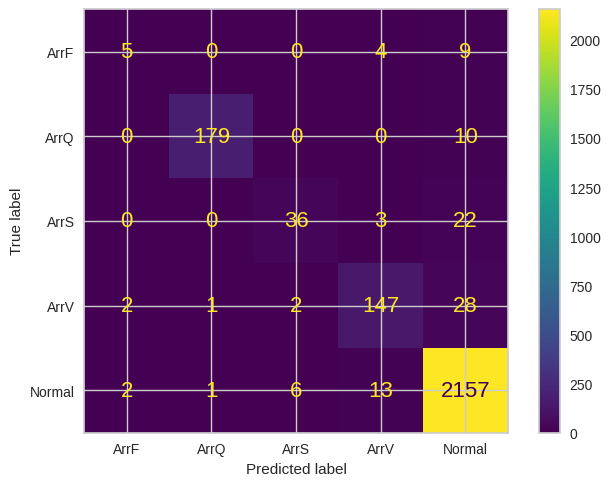

In [45]:
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_s,y_test, ax=plt.subplot());

Con respecto a los modelos anteriores vemos que hay muchas mejoras con respecto a ellos aunque hay casos de clases con una precisión o recuperación mayores. Pese a ello el valor de *f1_score* es practicamente mayor en casi cualquiera de ellos. No sería descabellado pensar que este es el modelo que mas se podria ajustar (para el caso del siguiente apartado)

## Apartado F

Una posibilidad que nos podemos plantear es obtener un modelo que sea capaz de distinguir
entre latidos normales y arritmias y luego tener un clasificador solo de arritmias. Escoged
el modelo que haya funcionado mejor y ajustadlo para tener un modelo para clasificar
normal/arritmia y para clasificar arritmias entre si. Usad la combinación del resultado de
los dos modelos para clasificar el conjunto de datos y comparad los resultados con los
modelos anteriores.

In [46]:
results_df.sort_values(by=['test acc'], ascending=False)

train XV acc  test acc  precision score (M)  \
KNN                       0.958     0.961                0.842   
Logistic                  0.906     0.903                0.720   
LDA                         NaN     0.872                0.556   
Logistic_balanced         0.678     0.692                0.437   
GNB                       0.184     0.187                0.332   

                   recall score (M)  f1 score (M)  
KNN                           0.724         0.770  
Logistic                      0.547         0.598  
LDA                           0.572         0.553  
Logistic_balanced             0.708         0.474  
GNB                           0.304         0.174

Vemos que KNN tiene la mejor precisión de todos los modelos estudiados. Ahora haremos un modelo combinado que pueda diferenciar los latidos normales de las arritmias y luego las arritmias entre ellas.

#### Clasificacion Normal/Arritmia
Procedemos a continuacion a dividir los datos para aplicar el knn para obtener un modelo que sea capaz de distinguir entre latidos normales y arritmias de la mejor forma posible

In [47]:
y_train_binary = np.where(y_train == 'Normal', 'Normal', 'Arritmia')
y_test_binary = np.where(y_test == 'Normal', 'Normal', 'Arritmia')

label_encoder_binary = LabelEncoder()
y_train_binary_encoded = label_encoder_binary.fit_transform(y_train_binary)
y_test_binary_encoded = label_encoder_binary.transform(y_test_binary)

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 11, 15, 17, 19, 21],
    'weights': ['distance', 'uniform'],
    'metric': ['l2', 'l1', 'cosine', 'euclidean', 'cityblock', 'manhattan', 'nan-euclidean']
}

knn_binary = KNeighborsClassifier()
knn_binary = GridSearchCV(knn_binary, param_grid, cv=cv, n_jobs=-1);

knn_binary.fit(X_train_s, y_train_binary_encoded)

y_pred_binary = knn_binary.predict(X_test_s)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['l2', 'l1', 'cosine', 'euclidean',
                                    'cityblock', 'manhattan', 'nan-euclidean'],
                         'n_neighbors': [1, 3, 5, 7, 11, 15, 17, 19, 21],
                         'weights': ['distance', 'uniform']})

In [48]:
print(classification_report(y_test_binary_encoded, y_pred_binary, target_names=label_encoder_binary.classes_))
results_df = save_results(knn_binary, X_test_s, y_test_binary_encoded, 'KNN_binary', results_df)

              precision    recall  f1-score   support

    Arritmia       0.93      0.88      0.90       448
      Normal       0.98      0.99      0.98      2179

    accuracy                           0.97      2627
   macro avg       0.95      0.93      0.94      2627
weighted avg       0.97      0.97      0.97      2627



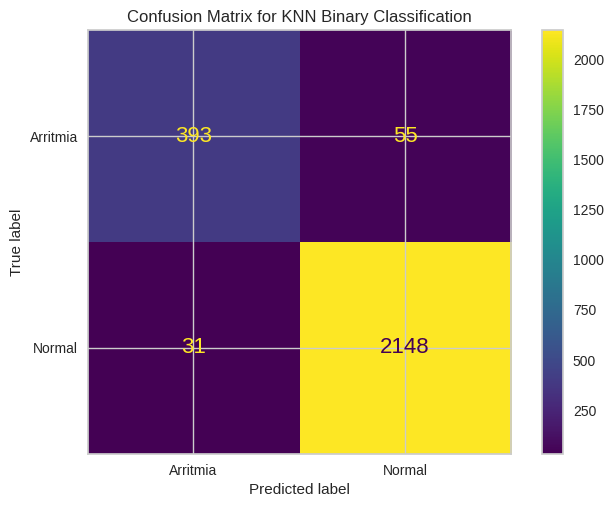

In [49]:
ConfusionMatrixDisplay.from_estimator(knn_binary, X_test_s, y_test_binary_encoded, display_labels=label_encoder_binary.classes_)
plt.title('Confusion Matrix for KNN Binary Classification')
plt.show();

Con el cambio de enfoque, de clasificar en si es un latido normal o el tipo de arritmia en concreto, a primeramente clasificar en si es o no un latido normal vemos que para esta fase (es o no normal) el modelo obtiene una mejora considerable. Esto tiene sentido pues en el modelo anterior de k-vecinos la precisión y recuperación de la clase Normal es practicamente perfecta.

Asi que como vemos, se obtienen resultados bastante interesantes, pese a que debido a la falta de datos de la clase minoritaria seguimos teniendo una mejor clasificacion de la clase mayoritaria.

#### Clasificación tipos de Arritmias
Procedemos ahora a cojer los datos clasificados como Arritmias por el primer KNN y trataremos las arritmias de forma aislada a las no arritmias.

In [50]:
arrhythmia_indices_train = y_train != 'Normal' 
arrhythmia_indices_test = y_pred_binary != 'Normal' 

X_train_arr = X_train_s[arrhythmia_indices_train]
y_train_arr = y_train[arrhythmia_indices_train]
X_test_arr = X_test_s[arrhythmia_indices_test]
y_test_arr = y_test[arrhythmia_indices_test]

non_normal_indices = y_test_arr != 'Normal'
y_test_arr = y_test_arr[non_normal_indices]
X_test_arr = X_test_arr[non_normal_indices]

label_encoder_arr = LabelEncoder()
y_train_arr_encoded = label_encoder_arr.fit_transform(y_train_arr)

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 11, 15, 17, 19, 21],
    'weights': ['distance', 'uniform'],
    'metric': ['l2', 'l1', 'cosine', 'euclidean', 'cityblock', 'manhattan', 'nan-euclidean']
}

knn_multiclass = KNeighborsClassifier()
knn_multiclass_gs = GridSearchCV(knn_multiclass, param_grid, cv=5, n_jobs=-1, refit=True)
knn_multiclass_gs.fit(X_train_arr, y_train_arr_encoded)

y_pred_arr = knn_multiclass_gs.predict(X_test_arr)

print("Mejores parámetros encontrados:", knn_multiclass_gs.best_params_)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['l2', 'l1', 'cosine', 'euclidean',
                                    'cityblock', 'manhattan', 'nan-euclidean'],
                         'n_neighbors': [1, 3, 5, 7, 11, 15, 17, 19, 21],
                         'weights': ['distance', 'uniform']})

Mejores parámetros encontrados: {'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}


In [51]:
y_pred_arr_labels = label_encoder_arr.inverse_transform(y_pred_arr)
y_test_arr_encoded = label_encoder_arr.transform(y_test_arr)
print(classification_report(y_test_arr_encoded, y_pred_arr, target_names=label_encoder_arr.classes_))
results_df = save_results(knn_multiclass_gs, X_test_arr, y_test_arr_encoded, 'KNN_arrhythmia', results_df)


              precision    recall  f1-score   support

        ArrF       0.79      0.61      0.69        18
        ArrQ       0.98      0.98      0.98       189
        ArrS       0.82      0.77      0.80        61
        ArrV       0.90      0.94      0.92       180

    accuracy                           0.92       448
   macro avg       0.87      0.83      0.85       448
weighted avg       0.92      0.92      0.92       448



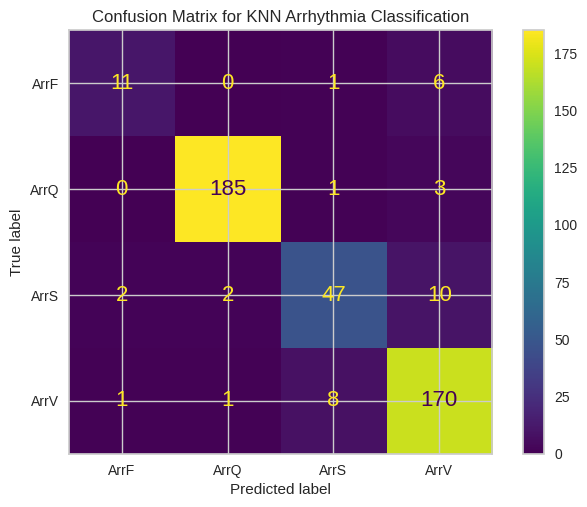

In [52]:
label_encoder_arr = LabelEncoder()
y_test_arr_encoded = label_encoder_arr.fit_transform(y_test_arr)

ConfusionMatrixDisplay.from_estimator(knn_multiclass_gs, X_test_arr, y_test_arr_encoded, display_labels=label_encoder_arr.classes_)
plt.title('Confusion Matrix for KNN Arrhythmia Classification')
plt.show();

En la segunda fase de clasificacion, habiendonos desecho de la clase normal, observamos mejoras en la precisión y recuperación de las clases (visto de forma global). En los anteriores modelos veiamos como estos estimaban en favor de la clase Normal a la hora de clasificar; ahora que solo tenemos en cuenta los casos de arritmia estos falsos negativos son menores. Aun así vemos que el modelo parece sobreestimar en favor de la classe ArrV, que para el caso de la clase ArrF (debido a la poca cantidad de datos) repercute en una recuperación bastante mas baja respecto a las demás.

Mostramos tambien a continuacion tambien los resultados y vemos que el knn binario obitene mejor resultado que el knn entrenado previamente

In [53]:
results_df.sort_values(by=['test acc'], ascending=False)

train XV acc  test acc  precision score (M)  \
KNN_binary                0.964     0.967                0.951   
KNN                       0.958     0.961                0.842   
KNN_arrhythmia            0.909     0.922                0.873   
Logistic                  0.906     0.903                0.720   
LDA                         NaN     0.872                0.556   
Logistic_balanced         0.678     0.692                0.437   
GNB                       0.184     0.187                0.332   

                   recall score (M)  f1 score (M)  
KNN_binary                    0.932         0.941  
KNN                           0.724         0.770  
KNN_arrhythmia                0.826         0.847  
Logistic                      0.547         0.598  
LDA                           0.572         0.553  
Logistic_balanced             0.708         0.474  
GNB                           0.304         0.174

#### Combinacion del resultado de los dos modelos

In [54]:
y_pred_arr_decoded = label_encoder_arr.inverse_transform(y_pred_arr)
y_pred_binary_decoded = label_encoder_binary.inverse_transform(y_pred_binary)

In [55]:
# First, use the binary KNN to classify the data into 'Normal' and 'Arritmia'
y_pred_binary_combined = knn_binary.predict(X_test_s)

# Create a mask for the arrhythmia predictions
arrhythmia_mask = y_pred_binary_combined == 0  # 0 corresponds to 'Arritmia'

# Use the arrhythmia KNN to classify the arrhythmia data
X_test_arr_combined = X_test_s[arrhythmia_mask]
y_pred_arr_combined = knn_multiclass_gs.predict(X_test_arr_combined)

# Decode the combined predictions
y_pred_combined_labels = y_pred_binary_decoded.copy()
y_pred_combined_labels[arrhythmia_mask] = label_encoder_arr.inverse_transform(y_pred_arr_combined)


In [56]:
print(classification_report(y_test, y_pred_combined_labels))

              precision    recall  f1-score   support

        ArrF       0.60      0.33      0.43        18
        ArrQ       0.98      0.96      0.97       189
        ArrS       0.73      0.62      0.67        61
        ArrV       0.87      0.86      0.86       180
      Normal       0.98      0.99      0.98      2179

    accuracy                           0.96      2627
   macro avg       0.83      0.75      0.78      2627
weighted avg       0.96      0.96      0.96      2627



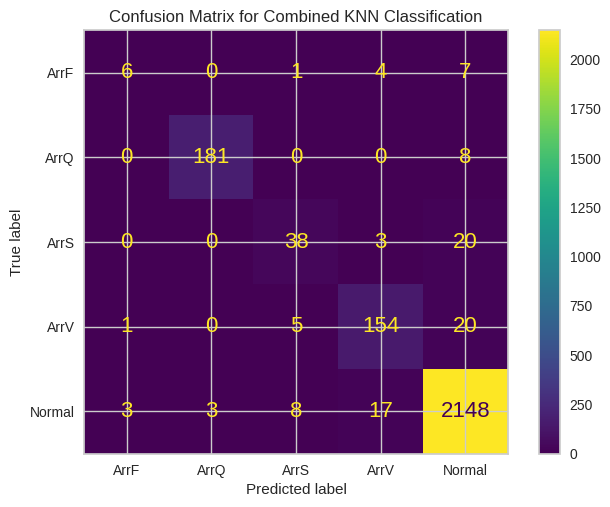

In [57]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_combined_labels)
plt.title('Confusion Matrix for Combined KNN Classification')
plt.show();

#### Conclusiones

Finalmente como vemos, con la combinación del resultado para clasificar el conjunto de datos los dos modelos de KNN, obtenemos unos resultados ligeramente mejores que los del KNN simple y por ende mejores que los resultados de todos los demas modelos.

Como era de esperar y como hemos ido comentado repetidamente en todos los anális, la falta de ejemplos de la clase minoritaria, influye en gran medida a la capacidad de los modelos que entrenamos ya que hace falta mas información para una mejor clasificación.

Sin embargo vemos como la propuesta que hemos ido mencionando en los apartados y que se nos ha pedido implementar en el apartado F, nos ha dado una mejoría que sería mucho mas significativa si tuviesemos muchos mas datos de esas instancias, dado que el balanceo de clases dentro del grupo Arritmia sigue siendo localmente bastante pobre, tenemos dos clases con muchos mas ejemplos que las otras 3.